In [1]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available

True


In [3]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer
import json

In [4]:
import gc  # Adicione esta importação no início do script
from IPython import get_ipython

# 1. Remova todas as referências ao modelo e dados
if 'model' in globals():
    del model  # Remove a referência do escopo global

if 'inputs' in globals():
    del inputs

# 2. Force a coleta de lixo
gc.collect()

# 3. Limpe o cache da CUDA
torch.cuda.empty_cache()

# 4. Verifique a memória liberada
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"\n✅ GPUs disponíveis: {num_gpus}\n")

    for i in range(num_gpus):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name}")
        print(f"  - Memória total: {props.total_memory / (1024 ** 3):.2f} GB")
        print(f"  - Memória livre: {torch.cuda.memory_reserved(i) / (1024 ** 3):.2f} GB (reservada)")
        print(f"  - Memória alocada: {torch.cuda.memory_allocated(i) / (1024 ** 3):.2f} GB (em uso)")
        print()
else:
    print("❌ Nenhuma GPU CUDA disponível.")


✅ GPUs disponíveis: 1

GPU 0: NVIDIA GeForce RTX 4060 Ti
  - Memória total: 15.70 GB
  - Memória livre: 0.00 GB (reservada)
  - Memória alocada: 0.00 GB (em uso)



In [5]:
lab_name = 'OpenGVLab'
model_name = 'InternVL2_5-1B'
model_name = 'InternVL2_5-2B'
model_name = 'InternVL3-8B'
# model_name = 'InternVL3-1B'
model_name = 'InternVL3-9B'
model_name = 'InternVL3-2B'
# model_name = 'InternVL3-1B'

# model_name = 'InternVL3-14B'

# model_name = 'InternVL2_5-4B'
# model_name = 'InternVL2_5-8B'
# model_name = 'InternVL2_5-4B-AWQ'
# model_name = 'InternVL2_5-8B-AWQ'

In [6]:
print(model_name)

InternVL3-2B


In [7]:
import sys
from pathlib import Path

# Caminho para a pasta src/ (um nível acima de notebooks/)
root_dir = Path.cwd().parent
src_dir = root_dir / "src"

# Adiciona src/ ao sys.path
sys.path.append(str(src_dir))

# Agora o import deve funcionar
from utils.image_utils import load_image, show_pair
from inference.classifier import classify_document

In [7]:
# lab_name = 'internvl-local'
# model_name = 'internvl_finetuned_1'

In [8]:
# !code ~/hf_models/internvl3-14b-completo/snapshots/17da586d2a2f259853f586fad16b02e6380e62b0/config.json


In [8]:
# Carregar modelo e processador do Deepseek
#model_path = "llava-hf/llava-v1.6-mistral-7b-hf"  ##LlavaNextProcessor, LlavaNextForConditionalGeneration
# model_path = "Intel/llava-llama-3-8b" ## AutoProcessor, AutoModelForPreTraining
# model_path = "THUDM/cogvlm2-llama3-chat-19B" ## AutoProcessor, AutoModelForCausalLM
model_path = f"{lab_name}/{model_name}" ## AutoProcessor, AutoModelForCausalLM
# model_path = "/home/joaopaulo/.cache/huggingface/hub/models--internvl-local--internvl_finetuned_1"

# Configuração de quantização (opcional)
quant_config = {
    "load_in_4bit": True,
    "bnb_4bit_compute_dtype": torch.bfloat16
}

# Carregar modelo e processador
processor = AutoProcessor.from_pretrained(model_path, 
                                        #   local_files_only=True, 
                                          trust_remote_code=True
                                          )

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    # local_files_only=True,  # 👈 fixa na versão atual (pode ser um commit exato também)
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    **quant_config
).eval()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, use_fast=False)

In [ ]:
# import pandas as pd

# df = pd.read_csv('../../testes_llm/zsl_protocol.csv')[['file1', 'file2', 'same_pattern']]
# df.columns = ['file_a_path','file_b_path','is_equal']

In [ ]:
# Extraindo o nome do arquivo
# df['file_a_name'] = df['file_a_path'].apply(lambda x: x.split('/')[-1])
# df['file_b_name'] = df['file_b_path'].apply(lambda x: x.split('/')[-1])

# # Extraindo o nome da classe
# df['class_a_name'] = df['file_a_path'].apply(lambda x: x.split('/')[0])
# df['class_b_name'] = df['file_b_path'].apply(lambda x: x.split('/')[0])

In [ ]:
# df[['file_a_name','file_b_name','class_a_name','class_b_name','file_a_path','file_b_path','is_equal']].to_csv('test_pairs.csv')

In [10]:
from data.documentpairs import DocumentPairDataset

dataset = DocumentPairDataset(
    csv_path="../src/data/test_pairs.csv",
    base_dir="../../../once-learning/separacao-rvl_cdip/",
    input_size=448,
    max_num=12,
    device="cuda"
)

In [11]:
from PIL import Image
import os

# Caminho local da pasta de imagens
pasta = "../../../once-learning/separacao-rvl_cdip/a_and_b_compound_results_summary"

# Lista para armazenar os dados
infos = []

# Percorre até 20 imagens para inspeção
for i, nome in enumerate(sorted(os.listdir(pasta))):
    if not nome.lower().endswith((".jpg", ".jpeg", ".png", ".tif")):
        continue

    caminho = os.path.join(pasta, nome)
    try:
        with Image.open(caminho) as img:
            infos.append({
                "arquivo": nome,
                "formato": img.format,
                "modo": img.mode,
                "dimensao": img.size  # (largura, altura)
            })
    except Exception as e:
        print(f"Erro ao ler {nome}: {e}")

    if i >= 19:
        break

# Mostra os primeiros resultados
import pandas as pd
df_infos = pd.DataFrame(infos)
print(df_infos)

         arquivo formato modo     dimensao
0   81302791.tif    TIFF    L  (802, 1000)
1   81302812.tif    TIFF    L  (802, 1000)
2   81302840.tif    TIFF    L  (802, 1000)
3   81302859.tif    TIFF    L  (754, 1000)
4   81302883.tif    TIFF    L  (754, 1000)
5   81302985.tif    TIFF    L  (802, 1000)
6   81303259.tif    TIFF    L  (771, 1000)
7   81303281.tif    TIFF    L  (771, 1000)
8   81303291.tif    TIFF    L  (773, 1000)
9   81303292.tif    TIFF    L  (772, 1000)
10  81303301.tif    TIFF    L  (773, 1000)
11  81303518.tif    TIFF    L  (772, 1000)
12  81303532.tif    TIFF    L  (773, 1000)
13  81303573.tif    TIFF    L  (774, 1000)
14  81303576.tif    TIFF    L  (772, 1000)
15  81303586.tif    TIFF    L  (774, 1000)
16  81303599.tif    TIFF    L  (773, 1000)
17  81303629.tif    TIFF    L  (773, 1000)
18  81303635.tif    TIFF    L  (773, 1000)
19  81303652.tif    TIFF    L  (772, 1000)


In [12]:
# Acessar os caminhos originais do primeiro item
import os

row = dataset.df.iloc[0]

reference_image_path = os.path.join(dataset.base_dir, row["file_a_path"])
image_path          = os.path.join(dataset.base_dir, row["file_b_path"])

In [ ]:
question = '''
            Image-1: <image>\nImage-2: <image>\n
            You are an AI assistant specialized in document analysis. Your task is to compare two company documents and assess their **visual similarity** based on their layout structure.

            **Instructions:**
            Analyze the two provided document images and measure their **visual similarity** based on:
            - **Shapes and Elements:** Compare the presence of graphical components, tables, sections, headers, and any other visual elements.
            - **Layout Consistency:** Evaluate the spatial arrangement of text blocks, margins, and alignments.
            - **Content Type:** Ensure that both documents contain similar types of content (e.g., tables, forms, paragraphs), regardless of specific wording.

            **Similarity Scoring:**
            Assign a **similarity score** between **0 and 100**, where:
            - **90-100** → **Nearly identical**: Documents have almost no visual differences.
            - **70-89** → **Highly similar**: Documents share the same structure with minor variations (e.g., small alignment changes).
            - **50-69** → **Moderately similar**: Key components remain, but there are noticeable structural differences.
            - **30-49** → **Weak similarity**: Some elements are shared, but the overall layout is significantly different.
            - **0-29** → **Completely different**: The documents do not share a recognizable visual structure.

            **Output Format:**
            Respond **only** with a JSON object structured as follows:
            ```json
            {
                "similarity_score": <value between 0 and 100>,
                "category": "<one of: Nearly Identical, Highly Similar, Moderately Similar, Weak Similarity, Completely Different>",
                "justification": "Briefly explain the key visual similarities or differences detected."
            }
'''

In [77]:
# Acessar os caminhos originais do primeiro item
import os

row = dataset.df.iloc[300]

reference_image_path = os.path.join(dataset.base_dir, row["file_a_path"])
image_path          = os.path.join(dataset.base_dir, row["file_b_path"])

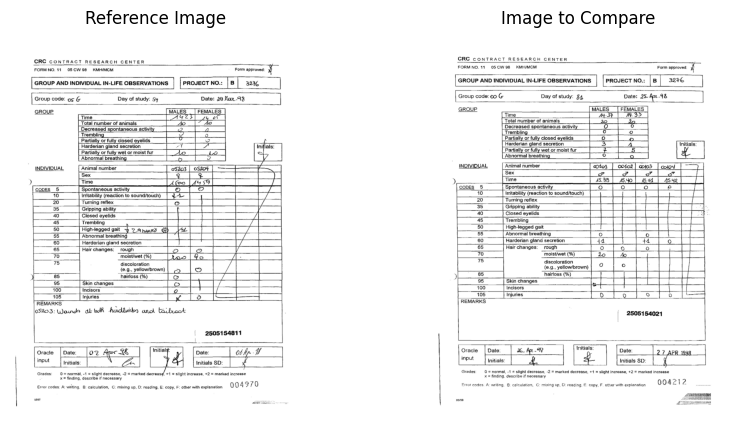

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


```json
{
  "similarity_score": 95,
  "category": "Nearly Identical",
  "justification": "Both documents have very similar layout structures, including headers, group and individual observations sections, and remark areas. The presence of tables, form numbers, and project codes is consistent. Minor alignment variations exist, but overall visual elements and content type are nearly identical."
}
```


In [79]:
# Mostrar as imagens lado a lado
show_pair(reference_image_path, image_path)

# Classificar o par usando o modelo InternVL3
resultado = classify_document(reference_image_path, image_path, model, tokenizer)
print(resultado)

In [14]:
# <image>
# <|vision_start|><|vision_end|>

question = '''
<image>

You are an AI assistant specialized in document analysis. Your task is to analyze the **layout and structure** of the provided company document image.

**Instructions:**
Carefully examine the image and focus on describing:
- **Shapes and Elements:** Presence of tables, sections, headers, logos, and graphical components.
- **Layout Consistency:** Alignment of text blocks, margins, and general spatial organization.
- **Content Type:** What kind of content the document predominantly contains (e.g., forms, paragraphs, tables).

**Objective:**
Generate a **compact internal representation** that captures the visual and structural characteristics of the document for similarity comparison.

**Important:**
- Do not perform OCR or extract textual content.
- Focus only on the **visual layout and structure**.

**Output:**
Provide a concise summary suitable for internal comparison tasks, without any conclusions about similarity.
'''

In [16]:
# Carregar pixel_values para cada imagem separadamente
pixel_values1 = load_image(reference_image_path, max_num=12).to(model.device)  # [N1, 3, 448, 448]
pixel_values2 = load_image(image_path, max_num=12).to(model.device)            # [N2, 3, 448, 448]

# CORREÇÃO: criar image_flags individuais
image_flags1 = torch.ones(pixel_values1.size(0), dtype=torch.long).to(model.device)  # [N1]
image_flags2 = torch.ones(pixel_values2.size(0), dtype=torch.long).to(model.device)  # [N2]

# Preparar o prompt adaptado (é o mesmo para as duas imagens)
inputs = tokenizer(question, return_tensors="pt").to(model.device)

In [17]:
def prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values, question, num_patches=None):
    device = model.device

    if '<image>' not in question:
        question = '<image>\n' + question

    if num_patches is None:
        num_patches = pixel_values.shape[0]  # número de blocos/imagens

    # Criar espaço de input para os vit_embeds
    image_tokens = '<img>' + ('<IMG_CONTEXT>' * model.num_image_token * num_patches) + '</img>'
    question = question.replace('<image>', image_tokens, 1)

    inputs = tokenizer(question, return_tensors='pt').to(device)
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'pixel_values': pixel_values.to(device),
        'image_flags': torch.ones(pixel_values.shape[0], dtype=torch.long).to(device)
    }

In [18]:
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

In [19]:
with torch.no_grad():
    inputs1 = prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values1, question)
    outputs1 = model(
        **inputs1,
        output_hidden_states=True,
        return_dict=True
    )

In [20]:
with torch.no_grad():
    inputs2 = prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values2, question)
    outputs2 = model(
        **inputs2,
        output_hidden_states=True,
        return_dict=True
    )

In [21]:
hidden_states1 = outputs1.hidden_states
embedding1 = hidden_states1[-1][0].mean(dim=0)  # ou outro ponto

In [25]:
hidden_states1[-1][0]#.mean(dim=0)

tensor([[ 3.5312, -0.1196, -0.2793,  ..., -0.7891,  0.1060,  0.9766],
        [-2.0312,  1.6094,  1.7812,  ..., -3.8125, -0.9609, -2.9062],
        [ 0.7031,  0.0977,  0.7266,  ..., -0.3730, -3.8438,  0.8281],
        ...,
        [ 2.4062,  0.1240, -1.0938,  ..., -3.4375, -1.9375, -4.0938],
        [ 0.1299,  4.5312,  1.8906,  ..., -1.8906, -0.7461, -0.9453],
        [-2.9531,  5.0938, -1.2422,  ...,  0.7305,  1.2812, -2.9062]],
       device='cuda:0', dtype=torch.bfloat16)

In [26]:
embedding1

tensor([-1.4297,  0.2812,  1.0859,  ..., -0.2910, -1.6406, -0.1299],
       device='cuda:0', dtype=torch.bfloat16)

In [28]:
hidden_states2 = outputs2.hidden_states
embedding2 = hidden_states2[-1][0].mean(dim=0)  # ou outro ponto

In [29]:
dist = torch.norm(embedding1 - embedding2, p=2).item()
print(f"Distância Euclidiana: {dist:.4f}")

Distância Euclidiana: 11.1250


In [30]:
import torch.nn.functional as F

sim = F.cosine_similarity(embedding1, embedding2, dim=0).item()
print(f"Similaridade Cosseno: {sim:.4f}")

Similaridade Cosseno: 0.9961


In [32]:
# from inspect import getsource
# print(getsource(model.chat))

In [31]:
from data.documentpairs import DocumentPairDataset

doc_dataset = DocumentPairDataset(
    csv_path="../src/data/train_pairs.csv",
    base_dir="../../../once-learning/separacao-rvl_cdip/",
    input_size=448,
    max_num=12,
    device="cuda"
)

In [77]:
# Contagem de parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal de parâmetros: {total_params:,}")
print(f"Parâmetros treináveis: {trainable_params:,}")
print(f"Proporção treinável: {100 * trainable_params / total_params:.2f}%")


Total de parâmetros: 1,280,178,433
Parâmetros treináveis: 1,639,169
Proporção treinável: 0.13%


In [33]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve
import wandb

# Inicializar wandb
wandb.init(
    project="siamese-internvl-zsl",
    name=f"ori-{model.config._name_or_path.replace('/', '-')}",
    config={
        "model": model.config._name_or_path,
        "embedding_strategy": "last_hidden_mean",
        "distance": "euclidean"
    }
)

distances = []
labels = []
inference_times = []

# Limpar cache antes de começar
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

for i in tqdm(range(len(dataset))):
    row = dataset.df.iloc[i]
    label = int(row["is_equal"])

    reference_image_path = os.path.join(dataset.base_dir, row["file_a_path"])
    image_path           = os.path.join(dataset.base_dir, row["file_b_path"])

    pixel_values1 = load_image(reference_image_path, max_num=12).to(model.device)
    pixel_values2 = load_image(image_path, max_num=12).to(model.device)

    inputs1 = prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values1, question)
    inputs2 = prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values2, question)

    start_time = time.time()

    with torch.no_grad():
        outputs1 = model(**inputs1, output_hidden_states=True, return_dict=True)
        outputs2 = model(**inputs2, output_hidden_states=True, return_dict=True)

    inference_time = time.time() - start_time
    inference_times.append(inference_time)

    embedding1 = outputs1.hidden_states[-1][0].mean(dim=0).cpu()
    embedding2 = outputs2.hidden_states[-1][0].mean(dim=0).cpu()
    distance = torch.norm(embedding1 - embedding2, p=2).item()

    distances.append(distance)
    labels.append(label)

# === Calcular EER ===
distances = np.array(distances)
labels = np.array(labels)

fpr, tpr, thresholds = roc_curve(labels, -distances)
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index]
eer_threshold = thresholds[eer_index]

# === Dados de uso de GPU ===
max_memory_allocated = torch.cuda.max_memory_allocated(device=model.device) / (1024 ** 2)  # em MB
max_memory_reserved  = torch.cuda.max_memory_reserved(device=model.device)  / (1024 ** 2)  # em MB
avg_inference_time   = np.mean(inference_times)

# === Logar no wandb ===
wandb.log({
    "eer": eer,
    "eer_threshold": -eer_threshold,
    "avg_inference_time": avg_inference_time,
    "max_memory_allocated_MB": max_memory_allocated,
    "max_memory_reserved_MB": max_memory_reserved
})

# === Gráfico de densidade ===
plt.figure(figsize=(10, 6))
sns.kdeplot(distances[labels == 1], label="Pares Iguais", shade=True, color="blue")
sns.kdeplot(distances[labels == 0], label="Pares Diferentes", shade=True, color="red")
plt.axvline(x=-eer_threshold, color='black', linestyle='--', label=f"Threshold EER ≈ {-eer_threshold:.2f}")
plt.title("Densidade das Distâncias Euclidianas")
plt.xlabel("Distância Euclidiana")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.tight_layout()

wandb.log({
    "densidade": wandb.Image(plt),
    "distancias_iguais": wandb.Histogram(distances[labels == 1]),
    "distancias_diferentes": wandb.Histogram(distances[labels == 0])
})
plt.close()

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jpcosta1990 (jpcosta1990-university-of-brasilia). Use `wandb login --relogin` to force relogin
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
  8%|▊         | 78/1036 [01:56<23:46,  1.49s/it]


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x74be5ed2dbd0>> (for post_run_cell), with arguments args (<ExecutionResult object at 74be5eea4390, execution_count=33 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 74be5ef9e250, raw_cell="import os
import time
import torch
import numpy as.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bserver-ia-joaopaulo/home/joaopaulo/Projects/internvl3-siamese/notebooks/siamese-internvl.ipynb#Y123sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [23]:
distances = np.array(distances)
labels = np.array(labels)

# Inverter o sinal da distância para usar como "score" (menor = mais similar)
fpr, tpr, thresholds = roc_curve(labels, -distances)
fnr = 1 - tpr

eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index]
eer_threshold = thresholds[eer_index]

print(f"EER: {eer:.4f} (threshold: {eer_threshold:.4f})")

EER: 0.0483 (threshold: -33.5000)


/tmp/ipykernel_96736/2830991679.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dist_iguais, label="Pares Iguais", shade=True, color="blue")
/tmp/ipykernel_96736/2830991679.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dist_diferentes, label="Pares Diferentes", shade=True, color="red")


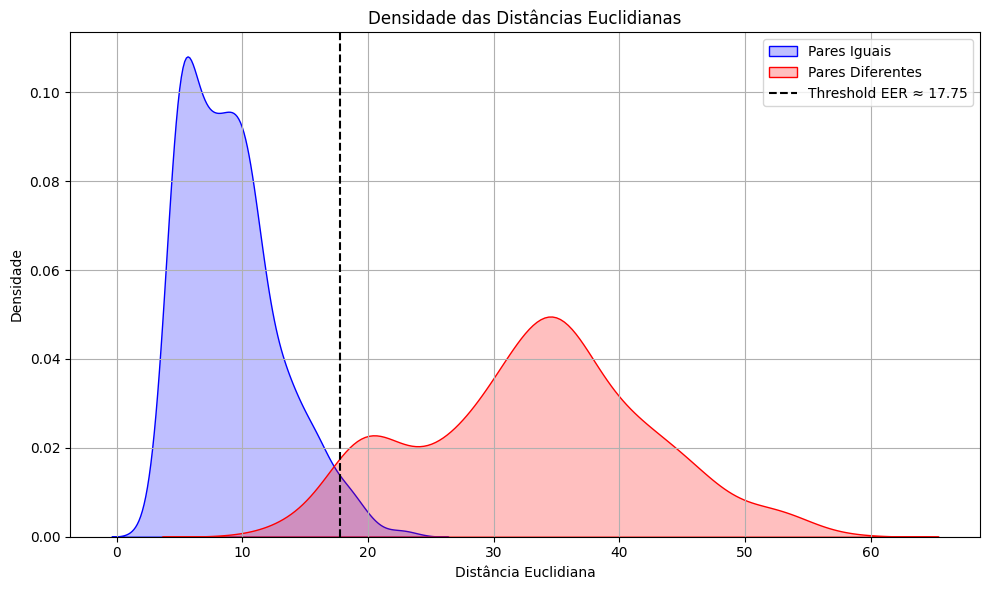

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Certifique-se de que distances e labels estão como np.array
distances = np.array(distances)
labels = np.array(labels)

# Separar os dados
dist_iguais = distances[labels == 1]
dist_diferentes = distances[labels == 0]

# Calcular o EER novamente para obter o threshold (caso não tenha salvo)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels, -distances)  # negativo porque menor distância = mais similar
fnr = 1 - tpr
eer_index = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_index]
eer_threshold = thresholds[eer_index]

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(dist_iguais, label="Pares Iguais", shade=True, color="blue")
sns.kdeplot(dist_diferentes, label="Pares Diferentes", shade=True, color="red")
plt.axvline(x=-eer_threshold, color='black', linestyle='--', label=f"Threshold EER ≈ {-eer_threshold:.2f}")
plt.title("Densidade das Distâncias Euclidianas")
plt.xlabel("Distância Euclidiana")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# Carregar pixel_values para cada imagem separadamente
pixel_values1 = load_image(reference_image_path, max_num=12).to(model.device)  
pixel_values2 = load_image(image_path, max_num=12).to(model.device)            

# CORREÇÃO: criar image_flags individuais
image_flags1 = torch.ones(pixel_values1.size(0), dtype=torch.long).to(model.device)
image_flags2 = torch.ones(pixel_values2.size(0), dtype=torch.long).to(model.device)

In [32]:
inputs = tokenizer(question, return_tensors="pt").to(model.device)

In [ ]:
def get_multimodal_embedding(image_path, question, model, tokenizer, max_num=12):
    import torch

    torch.cuda.empty_cache()
    # Pré-processar imagem
    pixel_values = load_image(image_path, max_num=max_num).to(model.device)
    print(image_path)
    image_flags = torch.ones(pixel_values.size(0), dtype=torch.long).to(model.device)

    # Tokenizar o prompt
    inputs = tokenizer(question, return_tensors="pt").to(model.device)

    # Rodar modelo com retorno de hidden_states
    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            pixel_values=pixel_values,
            image_flags=image_flags,
            return_dict=True,
            output_hidden_states=True,
        )

    # Identificar a posição do token <image> no input_ids
    image_token_id = tokenizer.convert_tokens_to_ids("<|vision_start|>")
    token_indices = (inputs["input_ids"][0] == image_token_id).nonzero(as_tuple=True)

    if len(token_indices[0]) == 0:
        raise ValueError("Token <image> não encontrado no prompt.")

    image_token_idx = token_indices[0].item()

    # Extrair o embedding do token <image> na última camada
    embedding = outputs.hidden_states[-1][0, image_token_idx, :]  # shape: [hidden_dim]

    return embedding.detach().cpu(), outputs.hidden_states

In [53]:
import torch
import torch.nn as nn

class SiameseInternVL3(nn.Module):
    def __init__(self, model, tokenizer, hidden_dim=5120):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.device = model.device
        self.mlp_head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    @torch.no_grad()
    def embed_image(self, pixel_values, question):
        inputs = self.tokenizer(question, return_tensors="pt").to(pixel_values.device)

        outputs = self.model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            pixel_values=pixel_values,
            image_flags=torch.ones(pixel_values.size(0), dtype=torch.long).to(pixel_values.device),
            return_dict=True,
            output_hidden_states=True
        )

        hidden = outputs.hidden_states[-1]
        embedding = hidden[:, -1, :]
        return embedding

    def prepare_inputs(self, pixel_values, question):
        # Recupera o token <IMG_CONTEXT>
        img_token = getattr(self.tokenizer, "img_context_token", "<IMG_CONTEXT>")
        num_patches = pixel_values.size(0)

        # Sempre substitui <image> por tokens visuais
        repeated = " ".join([img_token] * (pixel_values.shape[0]))  # pixel_values.shape[0] == N de patches
        question = question.replace("<image>", repeated)

        # Tokenizar após a substituição
        inputs = self.tokenizer(question, return_tensors="pt").to(self.device)

        # Verificação extra
        decoded = self.tokenizer.decode(inputs["input_ids"][0])
        print("\n[DEBUG] Prompt decodificado:")
        print(decoded)
        assert img_token in decoded, "[ERRO] Token visual ausente do prompt processado!"

        return inputs



    def forward(self, pixel_values_a, pixel_values_b, image_flags_a, image_flags_b, question):
        inputs_a = self.prepare_inputs(pixel_values_a, question)
        inputs_b = self.prepare_inputs(pixel_values_b, question)

        with torch.no_grad():
            outputs_a = self.model(
                input_ids=inputs_a["input_ids"],
                attention_mask=inputs_a["attention_mask"],
                pixel_values=pixel_values_a,
                image_flags=image_flags_a,
                return_dict=True,
                output_hidden_states=True
            )

            outputs_b = self.model(
                input_ids=inputs_b["input_ids"],
                attention_mask=inputs_b["attention_mask"],
                pixel_values=pixel_values_b,
                image_flags=image_flags_b,
                return_dict=True,
                output_hidden_states=True
            )

        # Mean pooling apenas nos tokens textuais válidos
        hidden_states_a = outputs_a.hidden_states[-1]  # [1, seq_len, hidden_dim]
        hidden_states_b = outputs_b.hidden_states[-1]

        attention_mask_a = inputs_a["attention_mask"].bool()
        attention_mask_b = inputs_b["attention_mask"].bool()

        text_embeds_a = hidden_states_a[attention_mask_a]
        text_embeds_b = hidden_states_b[attention_mask_b]

        emb_a = text_embeds_a.mean(dim=0, keepdim=True)
        emb_b = text_embeds_b.mean(dim=0, keepdim=True)

        # Concatenar e passar pelo head
        x = torch.cat([emb_a, emb_b], dim=-1).to(torch.float32)
        output = self.mlp_head(x).squeeze(1)
        return torch.sigmoid(output)

In [54]:
# Primeiro cria o modelo
siamese_model = SiameseInternVL3(model, tokenizer, hidden_dim=1536).to("cuda")

# Agora sim cria o criterion, optimizer e scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(siamese_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [55]:
# import wandb
# wandb.init(project="internvl3-siamese", name="run-1")

# Dentro do train_one_epoch
def train_one_epoch(model, dataloader, optimizer, criterion, device, question):
    model.train()
    total_loss = 0

    for batch in dataloader:
        pixel_values_a_batch = batch["image_a"][0]  # [N, 3, 448, 448]
        pixel_values_b_batch = batch["image_b"][0]
        targets_batch = batch["label"][0]

        pixel_values_a = pixel_values_a_batch.to(device)
        pixel_values_b = pixel_values_b_batch.to(device)
        if targets_batch.dim() == 0:
            target = targets_batch.unsqueeze(0).float().to(device)
        else:
            target = targets_batch[i].unsqueeze(0).float().to(device)

        image_flags_a = torch.ones(pixel_values_a.size(0), dtype=torch.long).to(device)
        image_flags_b = torch.ones(pixel_values_b.size(0), dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(
            pixel_values_a=pixel_values_a,
            pixel_values_b=pixel_values_b,
            image_flags_a=image_flags_a,
            image_flags_b=image_flags_b,
            question=question
        )
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # Logar no wandb
        # wandb.log({"train/loss": loss.item()})

        total_loss += loss.item()

    # wandb.log({"epoch/loss": total_loss / len(dataloader)})
    return total_loss / len(dataloader)


In [56]:
train_dataset = DocumentPairDataset(
    csv_path="../src/data/train_pairs.csv",
    base_dir="../../../once-learning/separacao-rvl_cdip/",
    input_size=448,
    max_num=12,
    device="cuda"
)

In [57]:
from torch.utils.data import DataLoader

# Hiperparâmetros
csv_path = "../src/data/train_pairs.csv"
base_dir = "../../../once-learning/separacao-rvl_cdip/"
batch_size = 1
num_epochs = 2
# question = "Compare the layout and structure of the document.\n<image>"

# Dataset e DataLoader
train_dataset = DocumentPairDataset(csv_path, base_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Modelo Siamese
# siamese_model = SiameseInternVL3(model, tokenizer).to("cuda")

# Treino
for epoch in range(num_epochs):
    loss = train_one_epoch(siamese_model, train_loader, optimizer, criterion, "cuda", question)
    scheduler.step()
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}")


[DEBUG] Prompt decodificado:

Image: <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT>

You are an AI assistant specialized in document analysis. Your task is to analyze the **layout and structure** of the provided company document image.

**Instructions:**
Carefully examine the image and focus on describing:
- **Shapes and Elements:** Presence of tables, sections, headers, logos, and graphical components.
- **Layout Consistency:** Alignment of text blocks, margins, and general spatial organization.
- **Content Type:** What kind of content the document predominantly contains (e.g., forms, paragraphs, tables).

**Objective:**
Generate a **compact internal representation** that captures the visual and structural characteristics of the document for similarity comparison.

**Important:**
- Do not perform OCR or extract textual content.
- Focus only on the **v

/home/joaopaulo/envs/pytorch/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/joaopaulo/envs/pytorch/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



[DEBUG] Prompt decodificado:

Image: <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT> <IMG_CONTEXT>

You are an AI assistant specialized in document analysis. Your task is to analyze the **layout and structure** of the provided company document image.

**Instructions:**
Carefully examine the image and focus on describing:
- **Shapes and Elements:** Presence of tables, sections, headers, logos, and graphical components.
- **Layout Consistency:** Alignment of text blocks, margins, and general spatial organization.
- **Content Type:** What kind of content the document predominantly contains (e.g., forms, paragraphs, tables).

**Objective:**
Generate a **compact internal representation** that captures the visual and structural characteristics of the document for similarity comparison.

**Important:**
- Do not perform OCR or extract textual content.
- Focus only on the **v

KeyboardInterrupt: 

In [22]:
wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x780dc769fa50>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 780d1ad08d10, raw_cell="wandb.finish()" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bserver-ia-joaopaulo/home/joaopaulo/Projects/internvl3-siamese/notebooks/finetune-head-only.ipynb#X61sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x780dc769fa50>> (for post_run_cell), with arguments args (<ExecutionResult object at 780d1ad08d50, execution_count=22 error_before_exec=None error_in_exec=[Errno 32] Broken pipe info=<ExecutionInfo object at 780d1ad08d10, raw_cell="wandb.finish()" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bserver-ia-joaopaulo/home/joaopaulo/Projects/internvl3-siamese/notebooks/finetune-head-only.ipynb#X61sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [10]:
import torch
from utils.image_utils import load_image  # usa seu pipeline: dynamic_preprocess + transform
from transformers import AutoProcessor, AutoModelForCausalLM

def preprocess_pair(image_path_a, image_path_b, max_blocks=6):
    pixel_values_a = load_image(image_path_a, max_num=max_blocks)
    pixel_values_b = load_image(image_path_b, max_num=max_blocks)
    pixel_values = torch.cat([pixel_values_a, pixel_values_b], dim=0)
    num_patches_list = [pixel_values_a.size(0), pixel_values_b.size(0)]
    return pixel_values, num_patches_list


class InternVLChatWithHiddenStates:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    @torch.no_grad()
    def chat_with_hidden(self, image_path_a, image_path_b, question=None, generation_config=None):
        # Default prompt
        if question is None:
            question = (
                "Image-1: <image>\nImage-2: <image>\n"
                "Compare layout and structure of the documents."
            )

        # Carrega e processa imagens
        pixel_values_a = load_image(image_path_a, use_thumbnail=False)  # [N1, 3, 448, 448]
        pixel_values_b = load_image(image_path_b, use_thumbnail=False)  # [N2, 3, 448, 448]
        pixel_values, num_patches_list = preprocess_pair(image_path_a, image_path_b)

        num_patches_list = [pixel_values_a.size(0), pixel_values_b.size(0)]
        image_flags = torch.ones((1, pixel_values.size(0)), dtype=torch.long).to(self.model.device)

        # Substitui os tokens visuais no prompt
        image_tokens = ''
        for n in num_patches_list:
            image_tokens += '<img>' + '<IMG_CONTEXT>' * (self.model.num_image_token * n) + '</img>\n'
        prompt = question.replace("<image>", image_tokens, 2)

        # Tokeniza e envia ao modelo
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        inputs["pixel_values"] = pixel_values.unsqueeze(0).to(self.model.device)
        inputs["image_flags"] = image_flags

        # Ajusta config de geração
        generation_config = generation_config or {}
        generation_config.setdefault("max_new_tokens", 512)

        # Forward com extração dos hidden states
        outputs = self.model(
            **inputs,
            return_dict=True,
            output_hidden_states=True
        )

        hidden_states = outputs.hidden_states[-1]  # Última camada textual
        generated_ids = self.model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            pixel_values=inputs["pixel_values"],
            image_flags=inputs["image_flags"],
            **generation_config
        )

        decoded = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return decoded, hidden_states


In [11]:
# Aplica o wrapper
chat_model = InternVLChatWithHiddenStates(model, tokenizer)

In [12]:
resposta, hidden = chat_model.chat_with_hidden(
    "../../../once-learning/separacao-rvl_cdip/action_TN_request/03669266.tif",
    "../../../once-learning/separacao-rvl_cdip/action_TN_request/03668166.tif"
)

print(resposta)
print(hidden.shape)

Token indices sequence length is longer than the specified maximum sequence length for this model (12318 > 12288). Running this sequence through the model will result in indexing errors


ValueError: wrong pixel_values size: torch.Size([1, 14, 3, 448, 448])

In [8]:
# Supondo que você já tenha: pixel_values e tokenizer
response, hidden = chat_model.chat_with_hidden(
    tokenizer=processor,
    pixel_values=pixel_values,
    question="Image-1: <image>\nCompare layout and structure.",
    generation_config={"max_new_tokens": 50},
    num_patches_list=[12]
)

NameError: name 'pixel_values' is not defined

In [79]:
import inspect
print(inspect.getsource(model.chat))

    def chat(self, tokenizer, pixel_values, question, generation_config, history=None, return_history=False,
             num_patches_list=None, IMG_START_TOKEN='<img>', IMG_END_TOKEN='</img>', IMG_CONTEXT_TOKEN='<IMG_CONTEXT>',
             verbose=False):

        if history is None and pixel_values is not None and '<image>' not in question:
            question = '<image>\n' + question

        if num_patches_list is None:
            num_patches_list = [pixel_values.shape[0]] if pixel_values is not None else []
        assert pixel_values is None or len(pixel_values) == sum(num_patches_list)

        img_context_token_id = tokenizer.convert_tokens_to_ids(IMG_CONTEXT_TOKEN)
        self.img_context_token_id = img_context_token_id

        template = get_conv_template(self.template)
        template.system_message = self.system_message
        eos_token_id = tokenizer.convert_tokens_to_ids(template.sep.strip())

        history = [] if history is None else history
        for (old_qu

In [13]:
# Exemplo
sample = dataset[0]
print(sample["image_a"].shape, sample["image_b"].shape, sample["label"])

torch.Size([10, 3, 448, 448]) torch.Size([10, 3, 448, 448]) 1.0


In [11]:
!code ~/.cache/huggingface/hub/models--OpenGVLab--InternVL3-14B/snapshots/17da586d2a2f259853f586fad16b02e6380e62b0/modeling_internvl_chat.py

In [23]:
import torch.nn as nn

class SiameseInternVL(nn.Module):
    def __init__(self, internvl_model, proj_dim=512, head_hidden=256):
        super().__init__()
        self.vit = internvl_model.vision_model
        vit_hidden = self.vit.config.hidden_size  # 👈 Correção aqui
        self.projector = nn.Linear(vit_hidden, proj_dim)

        self.sim_head = nn.Sequential(
            nn.Linear(proj_dim * 2, head_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(head_hidden, 1)
        )

    @torch.no_grad()
    def encode(self, img_tensor):
        """
        img_tensor: [B, 3, 448, 448]
        retorna: [B, proj_dim]
        """
        vit_out = self.vit(pixel_values=img_tensor)
        cls_embed = vit_out.last_hidden_state[:, 0, :]  # [B, hidden]
        return self.projector(cls_embed.to(torch.float32))  # 👈 conversão aqui

    def forward(self, img_a, img_b):
        emb_a = self.encode(img_a).mean(dim=0, keepdim=True)  # [1, 512]
        emb_b = self.encode(img_b).mean(dim=0, keepdim=True)
        x = torch.cat([emb_a, emb_b], dim=1)                  # [1, 1024]
        score = self.sim_head(x).squeeze(1)                   # [1]
        return torch.sigmoid(score)


In [17]:
import torch
import torch.nn as nn
from utils.image_utils import load_image
from pathlib import Path

class SiameseInternVLWithLLM(nn.Module):
    def __init__(self, model, tokenizer, proj_dim=5120, head_hidden=1024, aggregation="last_token"):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.aggregation = aggregation.lower()

        self.sim_head = nn.Sequential(
            nn.Linear(proj_dim * 2, head_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(head_hidden, 1)
        )

    @torch.no_grad()
    def encode(self, image_input):
        """
        image_input: caminho da imagem ou tensor [N, 3, 448, 448]
        Retorna: [1, proj_dim]
        """
        if isinstance(image_input, (str, Path)):
            pixel_values = load_image(image_input, use_thumbnail=False)
        elif isinstance(image_input, torch.Tensor):
            pixel_values = image_input
        else:
            raise ValueError("Input must be a file path or a torch.Tensor")

        if pixel_values.size(0) > 12:
            pixel_values = pixel_values[:12]

        prompt = "Compare the layout and structure of the following document.\n<image>"
        pixel_values = pixel_values.to(torch.bfloat16).to(self.model.device)

        response, hidden_states = self.model.chat(
            tokenizer=self.tokenizer,
            pixel_values=pixel_values,
            question=prompt,
            generation_config={"max_new_tokens": 1},
            return_hidden_states=True
        )

        last_layer = hidden_states[-1]  # [1, seq_len, hidden_dim]

        if self.aggregation == "mean":
            return last_layer.mean(dim=1)
        elif self.aggregation == "cls":
            return last_layer[:, 0, :]
        else:
            return last_layer[:, -1, :]  # último token textual (recomendado)

    def forward(self, image_a, image_b):
        emb_a = self.encode(image_a)
        emb_b = self.encode(image_b)
        x = torch.cat([emb_a, emb_b], dim=1)
        score = self.sim_head(x).squeeze(1)
        return torch.sigmoid(score)

In [19]:
siamese_llm = SiameseInternVLWithLLM(model, tokenizer).eval()

score = siamese_llm(
    "../../../once-learning/separacao-rvl_cdip/action_TN_request/03669266.tif",
    "../../../once-learning/separacao-rvl_cdip/action_TN_request/03668166.tif"
)

print(f"Score: {score.item():.4f}")


TypeError: InternVLChatModel.chat() got an unexpected keyword argument 'return_hidden_states'

In [ ]:
siamese_llm = SiameseInternVLWithLLM(model, processor).eval().cuda()

sample = dataset[0]
score = siamese_llm(sample["image_a"], sample["image_b"])
print("Score:", score.item())

TypeError: PreTrainedTokenizerFast._batch_encode_plus() got an unexpected keyword argument 'images'

In [21]:
siamese_model = SiameseInternVLWithLLM(model).eval().cuda()

In [22]:
scores = []
for a, b in zip(sample['image_a'], sample['image_b']):
    with torch.no_grad():
        s = siamese_model(a.unsqueeze(0), b.unsqueeze(0))
    scores.append(s)

final_score = torch.stack(scores).mean().item()
print(f"Score médio do par de documentos: {final_score:.4f}")

AttributeError: 'NoneType' object has no attribute 'squeeze'

In [18]:
from sklearn.metrics import roc_curve
import numpy as np

def compute_eer(y_true, y_scores):
    """
    Calcula o Equal Error Rate (EER) dado os rótulos e os scores.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return eer, eer_threshold


### Internvl 2B

In [58]:
all_scores = []
all_labels = []

for i in range(50):
    sample = dataset[i]
    with torch.no_grad():
        # Média dos embeddings para evitar mismatch de blocos
        emb_a = siamese_model.encode(sample["image_a"]).mean(dim=0, keepdim=True)
        emb_b = siamese_model.encode(sample["image_b"]).mean(dim=0, keepdim=True)
        x = torch.cat([emb_a, emb_b], dim=1)
        score = siamese_model.sim_head(x)
        score = torch.sigmoid(score).squeeze()
    
    all_scores.append(score.item())
    all_labels.append(sample["label"])

eer, threshold = compute_eer(all_labels, all_scores)
print(f"EER na amostra de 50 pares: {eer:.4f}")
print(f"Threshold correspondente: {threshold:.4f}")

EER na amostra de 50 pares: 0.4800
Threshold correspondente: 0.3560


### Internvl 14B

In [19]:
all_scores = []
all_labels = []

for i in range(50):
    sample = dataset[i]
    with torch.no_grad():
        # Média dos embeddings para evitar mismatch de blocos
        emb_a = siamese_model.encode(sample["image_a"]).mean(dim=0, keepdim=True)
        emb_b = siamese_model.encode(sample["image_b"]).mean(dim=0, keepdim=True)
        x = torch.cat([emb_a, emb_b], dim=1)
        score = siamese_model.sim_head(x)
        score = torch.sigmoid(score).squeeze()
    
    all_scores.append(score.item())
    all_labels.append(sample["label"])

eer, threshold = compute_eer(all_labels, all_scores)
print(f"EER na amostra de 50 pares: {eer:.4f}")
print(f"Threshold correspondente: {threshold:.4f}")

EER na amostra de 50 pares: 0.5600
Threshold correspondente: 0.5244


In [13]:
import pandas as pd
import json
import re

# Função aprimorada para extrair o similarity_score corretamente
def extract_similarity_score(response):
    if pd.isna(response):
        return None

    try:
        # Limpar formatação extra (```json ... ```)
        clean_response = re.sub(r"```json\n|\n```", "", response.strip())

        # Tentar carregar como JSON válido
        json_data = json.loads(clean_response)

        # Função recursiva para procurar similarity_score em qualquer nível do JSON
        def find_similarity_score(d):
            if isinstance(d, dict):
                if "similarity_score" in d:
                    return d["similarity_score"]
                for value in d.values():
                    result = find_similarity_score(value)
                    if result is not None:
                        return result
            return None

        score = find_similarity_score(json_data)
        if isinstance(score, int):  # Se for um número inteiro, retorna
            return score
        elif isinstance(score, str) and score.isdigit():  # Se for string numérica, converte
            return int(score)

    except json.JSONDecodeError:
        pass  # Continua para tentar outras extrações

    # Tentar extrair diretamente com regex caso JSON não esteja bem formatado
    match = re.search(r'"similarity_score"\s*:\s*(\d+)', response)
    if match:
        return int(match.group(1))

    return None  # Retorna None se não encontrou o similarity_score

In [14]:
from sklearn.metrics import roc_curve
import numpy as np

def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr

    eer_index = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[eer_index] + fnr[eer_index]) / 2
    eer_threshold = thresholds[eer_index]

    return eer, eer_threshold, fpr, fnr


In [15]:
import wandb
import time
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib
matplotlib.use('Agg')  # Usa backend não-interativo para evitar exibição no notebook

# Inicializa o projeto no wandb
wandb.init(
    project="comparacao-modelos-vl-zsl",
    name=f"inferência-{model_name}",
    config={"modelo": f"{model_name}"}
)

# Listas para cálculo do EER
y_true = []
y_scores = []

# Diretório base para os arquivos .tif
base_dir = "../../once-learning/separacao-rvl_cdip"

# Loop sobre o DataFrame
for idx, row in df.iterrows():
    file1 = os.path.join(base_dir, row["file1"])
    file2 = os.path.join(base_dir, row["file2"])
    label = int(row["same_pattern"])

    if not os.path.exists(file1) or not os.path.exists(file2):
        print(f"[{idx}] Arquivos ausentes: {file1} ou {file2}")
        continue

    # Marca o tempo antes da inferência
    start_time = time.time()

    try:
        # Inferência
        resultado = classificar_documento(file1, file2, model, tokenizer)
        elapsed_time = time.time() - start_time

        # Coleta de métricas de GPU após inferência
        gpu_memory_allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        gpu_memory_reserved = torch.cuda.memory_reserved() / (1024 ** 2)

        # Extrai o score
        score = extract_similarity_score(resultado)

        if score is None:
            print(f"[{idx}] Score não extraído.")
            continue

        # Acumula para cálculo de EER
        y_true.append(label)
        y_scores.append(score)

        img1 = Image.open(file1).convert("RGB")
        img2 = Image.open(file2).convert("RGB")

        # Combina as duas imagens lado a lado
        combined_width = img1.width + img2.width
        combined_height = max(img1.height, img2.height)
        combined_img = Image.new("RGB", (combined_width, combined_height))
        combined_img.paste(img1, (0, 0))
        combined_img.paste(img2, (img1.width, 0))

        # Log no wandb
        wandb.log({
            # "index": idx,
            # "file1": row["file1"],
            # "file2": row["file2"],
            "same_pattern": label,
            "similarity_score": score,
            "inference_time_sec": elapsed_time
            # "gpu_memory_allocated_mb": gpu_memory_allocated,
            # "gpu_memory_reserved_mb": gpu_memory_reserved,
            # "documentos_lado_a_lado": wandb.Image(combined_img, caption=f"{row['file1']} | {row['file2']}")
        })

        print(f"[{idx}] OK - Score: {score} | Tempo: {elapsed_time:.2f}s")

    except Exception as e:
        print(f"[{idx}] Erro na inferência: {e}")
        continue

# Cálculo do EER após todas as execuções
if y_true and y_scores:
    eer, eer_threshold, fpr, fnr = calculate_eer(y_true, y_scores)

    # Log final com o EER
    wandb.log({
        "EER": eer,
        "EER_threshold": eer_threshold
    })

    # print(f"\nEER final: {eer:.4f} (threshold: {eer_threshold:.2f})")

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jpcosta1990 (jpcosta1990-university-of-brasilia). Use `wandb login --relogin` to force relogin
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[0] OK - Score: 45 | Tempo: 4.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1] OK - Score: 29 | Tempo: 5.13s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[2] OK - Score: 50 | Tempo: 4.21s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[3] OK - Score: 50 | Tempo: 5.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[4] OK - Score: 80 | Tempo: 4.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[5] OK - Score: 35 | Tempo: 3.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[6] OK - Score: 70 | Tempo: 5.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[7] OK - Score: 50 | Tempo: 5.00s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[8] OK - Score: 50 | Tempo: 3.88s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[9] OK - Score: 30 | Tempo: 4.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[10] OK - Score: 35 | Tempo: 4.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[11] OK - Score: 30 | Tempo: 5.58s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[12] OK - Score: 50 | Tempo: 4.58s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[13] OK - Score: 20 | Tempo: 4.25s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[14] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[15] OK - Score: 50 | Tempo: 4.55s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[16] OK - Score: 30 | Tempo: 5.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[17] OK - Score: 30 | Tempo: 3.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[18] OK - Score: 50 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[19] OK - Score: 57 | Tempo: 5.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[20] OK - Score: 60 | Tempo: 4.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[21] OK - Score: 50 | Tempo: 5.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[22] OK - Score: 60 | Tempo: 4.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[23] OK - Score: 30 | Tempo: 5.58s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[24] OK - Score: 30 | Tempo: 4.11s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[25] OK - Score: 42 | Tempo: 4.26s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[26] OK - Score: 100 | Tempo: 5.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[27] OK - Score: 30 | Tempo: 4.79s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[28] OK - Score: 33 | Tempo: 5.02s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[29] OK - Score: 30 | Tempo: 4.71s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[30] OK - Score: 60 | Tempo: 4.56s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[31] OK - Score: 30 | Tempo: 4.42s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[32] OK - Score: 50 | Tempo: 4.47s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[33] OK - Score: 30 | Tempo: 5.58s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[34] OK - Score: 50 | Tempo: 4.88s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[35] OK - Score: 70 | Tempo: 4.63s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[36] OK - Score: 90 | Tempo: 6.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[37] OK - Score: 30 | Tempo: 4.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[38] OK - Score: 50 | Tempo: 5.11s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[39] OK - Score: 30 | Tempo: 7.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[40] OK - Score: 30 | Tempo: 4.00s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[41] OK - Score: 49 | Tempo: 4.82s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[42] OK - Score: 33 | Tempo: 4.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[43] OK - Score: 40 | Tempo: 5.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[44] OK - Score: 55 | Tempo: 3.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[45] OK - Score: 35 | Tempo: 4.63s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[46] OK - Score: 50 | Tempo: 3.83s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[47] OK - Score: 30 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[48] OK - Score: 60 | Tempo: 4.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[49] OK - Score: 30 | Tempo: 4.95s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[50] OK - Score: 63 | Tempo: 4.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[51] OK - Score: 40 | Tempo: 4.82s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[52] OK - Score: 50 | Tempo: 4.25s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[53] OK - Score: 50 | Tempo: 4.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[54] OK - Score: 33 | Tempo: 3.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[55] OK - Score: 33 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[56] OK - Score: 75 | Tempo: 4.95s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[57] OK - Score: 50 | Tempo: 3.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[58] OK - Score: 36 | Tempo: 6.13s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[59] OK - Score: 37 | Tempo: 4.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[60] OK - Score: 100 | Tempo: 3.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[61] OK - Score: 70 | Tempo: 4.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[62] OK - Score: 30 | Tempo: 4.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[63] OK - Score: 50 | Tempo: 4.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[64] OK - Score: 50 | Tempo: 4.23s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[65] OK - Score: 30 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[66] OK - Score: 50 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[67] OK - Score: 25 | Tempo: 4.82s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[68] OK - Score: 40 | Tempo: 4.01s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[69] OK - Score: 30 | Tempo: 4.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[70] OK - Score: 30 | Tempo: 5.21s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[71] OK - Score: 20 | Tempo: 3.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[72] OK - Score: 30 | Tempo: 4.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[73] OK - Score: 35 | Tempo: 4.17s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[74] OK - Score: 30 | Tempo: 4.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[75] OK - Score: 75 | Tempo: 5.01s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[76] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[77] OK - Score: 30 | Tempo: 3.58s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[78] OK - Score: 55 | Tempo: 4.64s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[79] OK - Score: 45 | Tempo: 5.83s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[80] OK - Score: 35 | Tempo: 4.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[81] OK - Score: 30 | Tempo: 4.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[82] OK - Score: 30 | Tempo: 4.00s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[83] OK - Score: 65 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[84] OK - Score: 70 | Tempo: 4.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[85] OK - Score: 50 | Tempo: 4.14s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[86] OK - Score: 26 | Tempo: 5.16s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[87] OK - Score: 30 | Tempo: 5.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[88] OK - Score: 30 | Tempo: 3.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[89] OK - Score: 30 | Tempo: 4.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[90] OK - Score: 50 | Tempo: 5.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[91] OK - Score: 30 | Tempo: 4.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[92] OK - Score: 40 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[93] OK - Score: 32 | Tempo: 4.36s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[94] OK - Score: 50 | Tempo: 4.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[95] OK - Score: 40 | Tempo: 4.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[96] OK - Score: 30 | Tempo: 3.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[97] OK - Score: 30 | Tempo: 3.79s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[98] OK - Score: 30 | Tempo: 3.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[99] OK - Score: 30 | Tempo: 5.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[100] OK - Score: 53 | Tempo: 5.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[101] OK - Score: 30 | Tempo: 4.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[102] OK - Score: 40 | Tempo: 5.28s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[103] OK - Score: 30 | Tempo: 4.64s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[104] OK - Score: 50 | Tempo: 4.33s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[105] OK - Score: 20 | Tempo: 4.58s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[106] OK - Score: 35 | Tempo: 5.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[107] OK - Score: 40 | Tempo: 4.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[108] OK - Score: 33 | Tempo: 4.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[109] OK - Score: 30 | Tempo: 4.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[110] OK - Score: 50 | Tempo: 4.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[111] OK - Score: 30 | Tempo: 4.46s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[112] OK - Score: 20 | Tempo: 5.29s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[113] OK - Score: 50 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[114] OK - Score: 30 | Tempo: 4.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[115] OK - Score: 30 | Tempo: 4.01s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[116] OK - Score: 40 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[117] OK - Score: 30 | Tempo: 4.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[118] OK - Score: 40 | Tempo: 4.06s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[119] OK - Score: 47 | Tempo: 4.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[120] OK - Score: 26 | Tempo: 4.33s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[121] OK - Score: 30 | Tempo: 5.17s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[122] OK - Score: 24 | Tempo: 4.16s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[123] OK - Score: 23 | Tempo: 5.63s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[124] OK - Score: 30 | Tempo: 4.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[125] OK - Score: 30 | Tempo: 4.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[126] OK - Score: 50 | Tempo: 7.23s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[127] OK - Score: 20 | Tempo: 5.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[128] OK - Score: 30 | Tempo: 4.71s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[129] OK - Score: 80 | Tempo: 4.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[130] OK - Score: 30 | Tempo: 4.23s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[131] OK - Score: 70 | Tempo: 4.29s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[132] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[133] OK - Score: 30 | Tempo: 4.77s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[134] OK - Score: 70 | Tempo: 5.00s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[135] OK - Score: 35 | Tempo: 6.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[136] OK - Score: 70 | Tempo: 3.83s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[137] OK - Score: 30 | Tempo: 5.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[138] OK - Score: 35 | Tempo: 5.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[139] OK - Score: 30 | Tempo: 5.23s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[140] OK - Score: 31 | Tempo: 5.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[141] OK - Score: 20 | Tempo: 4.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[142] OK - Score: 30 | Tempo: 4.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[143] OK - Score: 20 | Tempo: 5.77s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[144] OK - Score: 56 | Tempo: 4.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[145] OK - Score: 20 | Tempo: 4.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[146] OK - Score: 80 | Tempo: 4.18s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[147] OK - Score: 40 | Tempo: 4.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[148] OK - Score: 35 | Tempo: 6.33s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[149] OK - Score: 30 | Tempo: 4.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[150] OK - Score: 37 | Tempo: 5.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[151] OK - Score: 25 | Tempo: 5.99s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[152] OK - Score: 61 | Tempo: 4.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[153] OK - Score: 60 | Tempo: 5.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[154] OK - Score: 80 | Tempo: 4.94s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[155] OK - Score: 60 | Tempo: 4.20s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[156] OK - Score: 50 | Tempo: 4.94s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[157] OK - Score: 30 | Tempo: 5.08s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[158] OK - Score: 50 | Tempo: 3.77s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[159] OK - Score: 40 | Tempo: 4.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[160] OK - Score: 80 | Tempo: 4.31s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[161] OK - Score: 70 | Tempo: 5.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[162] Score não extraído.


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[163] OK - Score: 35 | Tempo: 5.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[164] OK - Score: 67 | Tempo: 3.95s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[165] OK - Score: 70 | Tempo: 3.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[166] OK - Score: 35 | Tempo: 5.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[167] OK - Score: 25 | Tempo: 4.36s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[168] OK - Score: 30 | Tempo: 3.88s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[169] OK - Score: 30 | Tempo: 3.95s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[170] OK - Score: 85 | Tempo: 4.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[171] OK - Score: 30 | Tempo: 5.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[172] OK - Score: 70 | Tempo: 4.53s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[173] OK - Score: 60 | Tempo: 5.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[174] OK - Score: 90 | Tempo: 5.18s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[175] OK - Score: 50 | Tempo: 4.14s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[176] OK - Score: 70 | Tempo: 4.53s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[177] OK - Score: 40 | Tempo: 5.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[178] OK - Score: 45 | Tempo: 4.20s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[179] OK - Score: 50 | Tempo: 5.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[180] OK - Score: 30 | Tempo: 4.18s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[181] OK - Score: 33 | Tempo: 4.45s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[182] OK - Score: 50 | Tempo: 4.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[183] OK - Score: 60 | Tempo: 5.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[184] OK - Score: 49 | Tempo: 4.45s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[185] OK - Score: 30 | Tempo: 5.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[186] OK - Score: 20 | Tempo: 4.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[187] OK - Score: 50 | Tempo: 6.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[188] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[189] OK - Score: 60 | Tempo: 4.88s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[190] OK - Score: 20 | Tempo: 4.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[191] OK - Score: 50 | Tempo: 4.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[192] OK - Score: 40 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[193] OK - Score: 30 | Tempo: 4.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[194] OK - Score: 34 | Tempo: 4.63s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[195] OK - Score: 35 | Tempo: 4.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[196] OK - Score: 60 | Tempo: 4.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[197] OK - Score: 37 | Tempo: 4.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[198] OK - Score: 30 | Tempo: 3.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[199] OK - Score: 50 | Tempo: 4.25s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[200] OK - Score: 80 | Tempo: 4.95s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[201] OK - Score: 50 | Tempo: 6.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[202] OK - Score: 75 | Tempo: 4.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[203] OK - Score: 33 | Tempo: 5.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[204] OK - Score: 50 | Tempo: 4.28s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[205] OK - Score: 45 | Tempo: 4.47s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[206] OK - Score: 50 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[207] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[208] OK - Score: 20 | Tempo: 4.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[209] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[210] OK - Score: 40 | Tempo: 5.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[211] OK - Score: 35 | Tempo: 4.26s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[212] OK - Score: 57 | Tempo: 4.14s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[213] OK - Score: 60 | Tempo: 6.42s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[214] OK - Score: 35 | Tempo: 5.04s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[215] OK - Score: 50 | Tempo: 4.72s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[216] OK - Score: 50 | Tempo: 4.76s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[217] OK - Score: 30 | Tempo: 4.21s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[218] OK - Score: 30 | Tempo: 5.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[219] OK - Score: 29 | Tempo: 7.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[220] OK - Score: 30 | Tempo: 5.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[221] OK - Score: 50 | Tempo: 4.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[222] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[223] OK - Score: 50 | Tempo: 4.66s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[224] OK - Score: 0 | Tempo: 3.53s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[225] OK - Score: 34 | Tempo: 5.16s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[226] OK - Score: 60 | Tempo: 5.26s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[227] OK - Score: 35 | Tempo: 4.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[228] OK - Score: 60 | Tempo: 6.31s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[229] OK - Score: 30 | Tempo: 4.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[230] OK - Score: 70 | Tempo: 4.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[231] OK - Score: 30 | Tempo: 5.09s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[232] OK - Score: 50 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[233] OK - Score: 30 | Tempo: 4.26s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[234] OK - Score: 70 | Tempo: 5.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[235] OK - Score: 65 | Tempo: 5.06s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[236] OK - Score: 30 | Tempo: 3.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[237] OK - Score: 37 | Tempo: 5.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[238] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[239] OK - Score: 30 | Tempo: 4.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[240] OK - Score: 70 | Tempo: 5.21s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[241] OK - Score: 50 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[242] OK - Score: 38 | Tempo: 4.69s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[243] OK - Score: 35 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[244] OK - Score: 35 | Tempo: 4.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[245] OK - Score: 50 | Tempo: 6.08s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[246] OK - Score: 30 | Tempo: 5.55s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[247] OK - Score: 30 | Tempo: 5.04s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[248] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[249] OK - Score: 30 | Tempo: 5.64s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[250] OK - Score: 49 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[251] OK - Score: 70 | Tempo: 4.76s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[252] OK - Score: 60 | Tempo: 4.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[253] OK - Score: 40 | Tempo: 4.69s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[254] OK - Score: 50 | Tempo: 4.31s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[255] OK - Score: 34 | Tempo: 3.47s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[256] OK - Score: 60 | Tempo: 4.76s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[257] OK - Score: 50 | Tempo: 5.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[258] OK - Score: 70 | Tempo: 5.36s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[259] OK - Score: 30 | Tempo: 4.69s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[260] OK - Score: 90 | Tempo: 4.64s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[261] OK - Score: 70 | Tempo: 3.73s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[262] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[263] OK - Score: 100 | Tempo: 5.29s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[264] OK - Score: 50 | Tempo: 4.42s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[265] OK - Score: 37 | Tempo: 6.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[266] OK - Score: 57 | Tempo: 4.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[267] OK - Score: 50 | Tempo: 3.67s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[268] OK - Score: 37 | Tempo: 3.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[269] OK - Score: 40 | Tempo: 5.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[270] OK - Score: 35 | Tempo: 5.14s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[271] OK - Score: 89 | Tempo: 4.17s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[272] OK - Score: 43 | Tempo: 4.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[273] OK - Score: 20 | Tempo: 4.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[274] OK - Score: 70 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[275] OK - Score: 70 | Tempo: 4.14s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[276] OK - Score: 60 | Tempo: 5.94s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[277] OK - Score: 60 | Tempo: 4.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[278] OK - Score: 70 | Tempo: 4.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[279] OK - Score: 25 | Tempo: 3.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[280] OK - Score: 50 | Tempo: 4.11s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[281] OK - Score: 30 | Tempo: 4.92s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[282] OK - Score: 60 | Tempo: 4.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[283] OK - Score: 26 | Tempo: 5.13s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[284] OK - Score: 69 | Tempo: 5.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[285] OK - Score: 30 | Tempo: 4.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[286] OK - Score: 50 | Tempo: 4.08s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[287] OK - Score: 60 | Tempo: 5.83s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[288] OK - Score: 66 | Tempo: 5.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[289] OK - Score: 30 | Tempo: 3.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[290] OK - Score: 90 | Tempo: 4.89s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[291] OK - Score: 25 | Tempo: 5.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[292] OK - Score: 40 | Tempo: 5.53s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[293] OK - Score: 50 | Tempo: 5.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[294] OK - Score: 35 | Tempo: 4.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[295] OK - Score: 36 | Tempo: 4.63s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[296] OK - Score: 35 | Tempo: 5.79s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[297] OK - Score: 35 | Tempo: 4.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[298] OK - Score: 70 | Tempo: 6.02s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[299] OK - Score: 30 | Tempo: 3.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[300] OK - Score: 60 | Tempo: 3.95s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[301] OK - Score: 37 | Tempo: 4.11s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[302] OK - Score: 30 | Tempo: 4.20s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[303] OK - Score: 30 | Tempo: 4.82s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[304] OK - Score: 50 | Tempo: 5.02s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[305] OK - Score: 70 | Tempo: 4.08s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[306] OK - Score: 52 | Tempo: 4.17s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[307] OK - Score: 30 | Tempo: 4.64s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[308] OK - Score: 70 | Tempo: 4.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[309] OK - Score: 50 | Tempo: 4.89s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[310] OK - Score: 60 | Tempo: 3.83s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[311] OK - Score: 80 | Tempo: 4.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[312] OK - Score: 60 | Tempo: 4.17s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[313] OK - Score: 70 | Tempo: 5.24s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[314] OK - Score: 50 | Tempo: 4.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[315] OK - Score: 60 | Tempo: 4.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[316] OK - Score: 65 | Tempo: 3.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[317] OK - Score: 30 | Tempo: 3.65s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[318] OK - Score: 50 | Tempo: 4.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[319] OK - Score: 60 | Tempo: 5.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[320] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[321] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[322] OK - Score: 50 | Tempo: 3.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[323] OK - Score: 30 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[324] OK - Score: 30 | Tempo: 5.33s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[325] OK - Score: 33 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[326] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[327] OK - Score: 20 | Tempo: 4.69s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[328] OK - Score: 50 | Tempo: 4.84s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[329] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[330] OK - Score: 80 | Tempo: 4.07s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[331] OK - Score: 31 | Tempo: 4.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[332] OK - Score: 50 | Tempo: 4.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[333] OK - Score: 50 | Tempo: 4.40s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[334] OK - Score: 60 | Tempo: 4.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[335] OK - Score: 35 | Tempo: 5.31s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[336] OK - Score: 50 | Tempo: 3.55s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[337] OK - Score: 50 | Tempo: 6.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[338] OK - Score: 0 | Tempo: 4.84s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[339] OK - Score: 50 | Tempo: 4.79s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[340] OK - Score: 80 | Tempo: 4.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[341] OK - Score: 50 | Tempo: 4.46s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[342] OK - Score: 44 | Tempo: 5.01s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[343] OK - Score: 35 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[344] OK - Score: 40 | Tempo: 4.04s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[345] OK - Score: 65 | Tempo: 5.46s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[346] OK - Score: 70 | Tempo: 3.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[347] OK - Score: 70 | Tempo: 5.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[348] OK - Score: 40 | Tempo: 4.07s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[349] OK - Score: 30 | Tempo: 5.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[350] OK - Score: 30 | Tempo: 4.66s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[351] OK - Score: 30 | Tempo: 5.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[352] OK - Score: 40 | Tempo: 4.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[353] OK - Score: 50 | Tempo: 5.35s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[354] OK - Score: 30 | Tempo: 4.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[355] OK - Score: 25 | Tempo: 4.47s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[356] OK - Score: 30 | Tempo: 4.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[357] OK - Score: 30 | Tempo: 4.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[358] OK - Score: 90 | Tempo: 4.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[359] OK - Score: 33 | Tempo: 5.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[360] OK - Score: 54 | Tempo: 4.72s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[361] OK - Score: 40 | Tempo: 5.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[362] OK - Score: 80 | Tempo: 4.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[363] OK - Score: 30 | Tempo: 4.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[364] OK - Score: 30 | Tempo: 4.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[365] OK - Score: 30 | Tempo: 4.45s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[366] OK - Score: 50 | Tempo: 4.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[367] OK - Score: 33 | Tempo: 4.45s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[368] OK - Score: 40 | Tempo: 5.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[369] OK - Score: 50 | Tempo: 4.47s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[370] OK - Score: 30 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[371] OK - Score: 30 | Tempo: 3.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[372] OK - Score: 60 | Tempo: 5.09s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[373] OK - Score: 30 | Tempo: 4.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[374] OK - Score: 31 | Tempo: 5.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[375] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[376] OK - Score: 70 | Tempo: 5.46s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[377] OK - Score: 20 | Tempo: 4.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[378] OK - Score: 50 | Tempo: 4.41s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[379] OK - Score: 20 | Tempo: 5.95s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[380] OK - Score: 37 | Tempo: 4.55s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[381] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[382] OK - Score: 70 | Tempo: 5.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[383] OK - Score: 20 | Tempo: 4.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[384] OK - Score: 90 | Tempo: 5.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[385] OK - Score: 80 | Tempo: 4.31s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[386] OK - Score: 70 | Tempo: 4.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[387] OK - Score: 30 | Tempo: 4.02s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[388] OK - Score: 60 | Tempo: 4.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[389] OK - Score: 25 | Tempo: 4.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[390] OK - Score: 30 | Tempo: 4.18s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[391] OK - Score: 30 | Tempo: 4.83s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[392] OK - Score: 40 | Tempo: 5.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[393] OK - Score: 50 | Tempo: 3.66s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[394] OK - Score: 70 | Tempo: 4.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[395] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[396] OK - Score: 85 | Tempo: 5.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[397] OK - Score: 50 | Tempo: 4.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[398] OK - Score: 40 | Tempo: 5.11s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[399] OK - Score: 30 | Tempo: 4.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[400] OK - Score: 80 | Tempo: 3.71s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[401] OK - Score: 30 | Tempo: 4.71s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[402] OK - Score: 38 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[403] OK - Score: 30 | Tempo: 4.56s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[404] OK - Score: 50 | Tempo: 4.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[405] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[406] OK - Score: 90 | Tempo: 4.28s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[407] OK - Score: 70 | Tempo: 7.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[408] OK - Score: 65 | Tempo: 4.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[409] OK - Score: 50 | Tempo: 5.18s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[410] OK - Score: 40 | Tempo: 4.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[411] OK - Score: 0 | Tempo: 4.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[412] OK - Score: 50 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[413] OK - Score: 70 | Tempo: 4.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[414] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[415] OK - Score: 20 | Tempo: 4.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[416] OK - Score: 60 | Tempo: 5.35s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[417] OK - Score: 30 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[418] OK - Score: 42 | Tempo: 5.16s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[419] OK - Score: 65 | Tempo: 4.46s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[420] OK - Score: 50 | Tempo: 4.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[421] OK - Score: 50 | Tempo: 6.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[422] OK - Score: 20 | Tempo: 4.82s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[423] OK - Score: 50 | Tempo: 4.65s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[424] OK - Score: 50 | Tempo: 4.69s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[425] OK - Score: 70 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[426] OK - Score: 57 | Tempo: 4.82s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[427] OK - Score: 30 | Tempo: 4.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[428] OK - Score: 80 | Tempo: 5.62s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[429] OK - Score: 39 | Tempo: 5.23s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[430] OK - Score: 40 | Tempo: 5.02s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[431] OK - Score: 50 | Tempo: 3.65s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[432] OK - Score: 90 | Tempo: 4.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[433] OK - Score: 50 | Tempo: 4.23s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[434] OK - Score: 40 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[435] OK - Score: 50 | Tempo: 4.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[436] OK - Score: 50 | Tempo: 4.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[437] OK - Score: 30 | Tempo: 6.41s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[438] OK - Score: 30 | Tempo: 4.06s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[439] OK - Score: 30 | Tempo: 5.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[440] OK - Score: 60 | Tempo: 5.35s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[441] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[442] OK - Score: 50 | Tempo: 4.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[443] OK - Score: 70 | Tempo: 4.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[444] OK - Score: 40 | Tempo: 4.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[445] OK - Score: 35 | Tempo: 6.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[446] OK - Score: 35 | Tempo: 4.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[447] OK - Score: 50 | Tempo: 4.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[448] OK - Score: 50 | Tempo: 5.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[449] OK - Score: 30 | Tempo: 4.66s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[450] OK - Score: 60 | Tempo: 4.45s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[451] OK - Score: 50 | Tempo: 4.41s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[452] OK - Score: 33 | Tempo: 5.79s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[453] OK - Score: 30 | Tempo: 4.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[454] OK - Score: 85 | Tempo: 4.31s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[455] OK - Score: 30 | Tempo: 6.28s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[456] OK - Score: 30 | Tempo: 3.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[457] OK - Score: 30 | Tempo: 4.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[458] OK - Score: 50 | Tempo: 4.64s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[459] OK - Score: 49 | Tempo: 4.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[460] OK - Score: 30 | Tempo: 4.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[461] OK - Score: 20 | Tempo: 4.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[462] OK - Score: 37 | Tempo: 6.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[463] OK - Score: 20 | Tempo: 5.14s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[464] OK - Score: 81 | Tempo: 5.28s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[465] OK - Score: 35 | Tempo: 5.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[466] OK - Score: 40 | Tempo: 6.13s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[467] OK - Score: 25 | Tempo: 4.73s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[468] OK - Score: 50 | Tempo: 5.42s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[469] OK - Score: 33 | Tempo: 4.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[470] OK - Score: 70 | Tempo: 4.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[471] OK - Score: 40 | Tempo: 5.84s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[472] OK - Score: 30 | Tempo: 4.72s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[473] OK - Score: 70 | Tempo: 5.47s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[474] OK - Score: 25 | Tempo: 5.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[475] OK - Score: 35 | Tempo: 3.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[476] OK - Score: 70 | Tempo: 5.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[477] OK - Score: 30 | Tempo: 4.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[478] OK - Score: 60 | Tempo: 4.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[479] OK - Score: 50 | Tempo: 4.72s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[480] OK - Score: 65 | Tempo: 5.67s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[481] OK - Score: 50 | Tempo: 4.71s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[482] OK - Score: 43 | Tempo: 4.09s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[483] OK - Score: 30 | Tempo: 4.25s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[484] OK - Score: 30 | Tempo: 4.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[485] OK - Score: 30 | Tempo: 6.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[486] OK - Score: 30 | Tempo: 5.46s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[487] OK - Score: 76 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[488] OK - Score: 60 | Tempo: 4.21s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[489] OK - Score: 20 | Tempo: 6.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[490] OK - Score: 35 | Tempo: 5.28s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[491] OK - Score: 33 | Tempo: 4.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[492] OK - Score: 60 | Tempo: 4.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[493] OK - Score: 30 | Tempo: 5.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[494] OK - Score: 63 | Tempo: 4.29s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[495] OK - Score: 40 | Tempo: 3.66s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[496] OK - Score: 70 | Tempo: 4.21s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[497] OK - Score: 30 | Tempo: 5.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[498] OK - Score: 80 | Tempo: 4.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[499] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[500] OK - Score: 30 | Tempo: 4.71s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[501] OK - Score: 50 | Tempo: 4.13s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[502] OK - Score: 50 | Tempo: 4.76s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[503] OK - Score: 50 | Tempo: 6.56s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[504] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[505] OK - Score: 30 | Tempo: 4.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[506] OK - Score: 50 | Tempo: 4.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[507] OK - Score: 30 | Tempo: 5.26s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[508] OK - Score: 70 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[509] OK - Score: 0 | Tempo: 4.01s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[510] OK - Score: 70 | Tempo: 5.13s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[511] OK - Score: 40 | Tempo: 5.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[512] OK - Score: 75 | Tempo: 4.63s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[513] OK - Score: 30 | Tempo: 4.31s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[514] OK - Score: 30 | Tempo: 4.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[515] OK - Score: 30 | Tempo: 4.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[516] OK - Score: 50 | Tempo: 4.45s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[517] OK - Score: 50 | Tempo: 3.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[518] OK - Score: 50 | Tempo: 4.35s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[519] OK - Score: 23 | Tempo: 5.45s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[520] OK - Score: 82 | Tempo: 4.95s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[521] OK - Score: 30 | Tempo: 4.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[522] OK - Score: 50 | Tempo: 5.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[523] OK - Score: 70 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[524] OK - Score: 35 | Tempo: 6.67s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[525] OK - Score: 43 | Tempo: 4.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[526] OK - Score: 72 | Tempo: 4.28s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[527] OK - Score: 65 | Tempo: 4.58s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[528] OK - Score: 85 | Tempo: 5.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[529] OK - Score: 30 | Tempo: 5.17s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[530] OK - Score: 69 | Tempo: 5.14s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[531] OK - Score: 35 | Tempo: 5.08s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[532] OK - Score: 70 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[533] OK - Score: 20 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[534] OK - Score: 70 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[535] OK - Score: 50 | Tempo: 4.04s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[536] OK - Score: 35 | Tempo: 4.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[537] OK - Score: 30 | Tempo: 5.62s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[538] OK - Score: 60 | Tempo: 5.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[539] OK - Score: 33 | Tempo: 3.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[540] OK - Score: 30 | Tempo: 4.35s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[541] OK - Score: 30 | Tempo: 6.02s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[542] OK - Score: 30 | Tempo: 4.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[543] OK - Score: 20 | Tempo: 3.58s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[544] OK - Score: 55 | Tempo: 5.24s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[545] OK - Score: 30 | Tempo: 4.46s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[546] OK - Score: 50 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[547] OK - Score: 70 | Tempo: 5.04s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[548] OK - Score: 80 | Tempo: 4.42s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[549] OK - Score: 20 | Tempo: 5.31s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[550] OK - Score: 45 | Tempo: 5.12s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[551] OK - Score: 0 | Tempo: 4.42s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[552] OK - Score: 50 | Tempo: 4.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[553] OK - Score: 30 | Tempo: 4.45s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[554] OK - Score: 65 | Tempo: 4.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[555] OK - Score: 30 | Tempo: 6.12s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[556] OK - Score: 65 | Tempo: 4.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[557] OK - Score: 50 | Tempo: 4.99s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[558] OK - Score: 43 | Tempo: 4.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[559] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[560] OK - Score: 60 | Tempo: 5.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[561] OK - Score: 20 | Tempo: 5.04s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[562] OK - Score: 30 | Tempo: 4.89s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[563] OK - Score: 33 | Tempo: 4.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[564] OK - Score: 60 | Tempo: 4.24s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[565] OK - Score: 30 | Tempo: 4.16s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[566] OK - Score: 60 | Tempo: 4.73s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[567] OK - Score: 30 | Tempo: 4.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[568] OK - Score: 40 | Tempo: 4.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[569] OK - Score: 20 | Tempo: 4.13s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[570] OK - Score: 50 | Tempo: 4.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[571] OK - Score: 50 | Tempo: 4.46s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[572] OK - Score: 70 | Tempo: 4.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[573] OK - Score: 50 | Tempo: 4.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[574] OK - Score: 50 | Tempo: 4.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[575] OK - Score: 30 | Tempo: 4.17s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[576] OK - Score: 38 | Tempo: 4.53s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[577] OK - Score: 30 | Tempo: 4.04s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[578] OK - Score: 70 | Tempo: 4.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[579] OK - Score: 20 | Tempo: 3.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[580] OK - Score: 70 | Tempo: 5.45s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[581] OK - Score: 49 | Tempo: 3.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[582] OK - Score: 50 | Tempo: 4.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[583] OK - Score: 30 | Tempo: 4.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[584] OK - Score: 31 | Tempo: 4.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[585] OK - Score: 50 | Tempo: 5.01s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[586] OK - Score: 90 | Tempo: 5.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[587] OK - Score: 30 | Tempo: 5.28s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[588] OK - Score: 60 | Tempo: 5.23s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[589] OK - Score: 50 | Tempo: 4.69s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[590] OK - Score: 70 | Tempo: 4.56s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[591] OK - Score: 30 | Tempo: 7.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[592] OK - Score: 70 | Tempo: 4.72s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[593] OK - Score: 30 | Tempo: 4.65s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[594] OK - Score: 50 | Tempo: 5.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[595] OK - Score: 34 | Tempo: 4.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[596] OK - Score: 60 | Tempo: 6.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[597] OK - Score: 25 | Tempo: 5.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[598] OK - Score: 70 | Tempo: 5.28s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[599] OK - Score: 50 | Tempo: 5.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[600] OK - Score: 80 | Tempo: 5.02s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[601] OK - Score: 30 | Tempo: 4.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[602] OK - Score: 35 | Tempo: 4.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[603] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[604] OK - Score: 40 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[605] OK - Score: 35 | Tempo: 5.94s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[606] OK - Score: 90 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[607] OK - Score: 50 | Tempo: 5.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[608] OK - Score: 33 | Tempo: 4.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[609] OK - Score: 30 | Tempo: 4.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[610] OK - Score: 35 | Tempo: 4.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[611] OK - Score: 0 | Tempo: 3.82s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[612] OK - Score: 84 | Tempo: 4.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[613] OK - Score: 70 | Tempo: 3.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[614] OK - Score: 70 | Tempo: 5.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[615] OK - Score: 30 | Tempo: 4.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[616] OK - Score: 30 | Tempo: 4.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[617] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[618] OK - Score: 33 | Tempo: 4.94s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[619] OK - Score: 60 | Tempo: 5.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[620] OK - Score: 78 | Tempo: 5.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[621] OK - Score: 70 | Tempo: 4.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[622] OK - Score: 50 | Tempo: 5.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[623] OK - Score: 30 | Tempo: 5.41s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[624] OK - Score: 49 | Tempo: 4.41s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[625] OK - Score: 34 | Tempo: 4.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[626] OK - Score: 20 | Tempo: 4.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[627] OK - Score: 30 | Tempo: 4.92s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[628] OK - Score: 30 | Tempo: 4.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[629] OK - Score: 56 | Tempo: 4.35s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[630] OK - Score: 50 | Tempo: 4.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[631] OK - Score: 50 | Tempo: 4.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[632] OK - Score: 30 | Tempo: 5.89s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[633] OK - Score: 30 | Tempo: 3.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[634] OK - Score: 40 | Tempo: 4.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[635] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[636] OK - Score: 30 | Tempo: 4.62s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[637] OK - Score: 40 | Tempo: 5.09s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[638] OK - Score: 80 | Tempo: 5.55s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[639] OK - Score: 24 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[640] OK - Score: 70 | Tempo: 5.40s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[641] OK - Score: 50 | Tempo: 4.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[642] OK - Score: 70 | Tempo: 5.35s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[643] OK - Score: 30 | Tempo: 3.99s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[644] OK - Score: 40 | Tempo: 4.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[645] OK - Score: 30 | Tempo: 4.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[646] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[647] OK - Score: 70 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[648] OK - Score: 50 | Tempo: 4.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[649] OK - Score: 30 | Tempo: 3.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[650] OK - Score: 60 | Tempo: 5.69s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[651] OK - Score: 30 | Tempo: 5.71s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[652] OK - Score: 55 | Tempo: 4.53s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[653] OK - Score: 25 | Tempo: 4.04s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[654] OK - Score: 55 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[655] OK - Score: 50 | Tempo: 5.54s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[656] OK - Score: 40 | Tempo: 4.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[657] OK - Score: 50 | Tempo: 4.41s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[658] OK - Score: 50 | Tempo: 4.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[659] OK - Score: 80 | Tempo: 4.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[660] OK - Score: 40 | Tempo: 4.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[661] OK - Score: 30 | Tempo: 4.11s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[662] OK - Score: 50 | Tempo: 4.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[663] OK - Score: 30 | Tempo: 4.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[664] OK - Score: 30 | Tempo: 3.95s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[665] OK - Score: 30 | Tempo: 4.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[666] OK - Score: 80 | Tempo: 5.24s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[667] OK - Score: 50 | Tempo: 3.82s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[668] OK - Score: 46 | Tempo: 4.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[669] OK - Score: 65 | Tempo: 4.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[670] OK - Score: 60 | Tempo: 4.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[671] OK - Score: 20 | Tempo: 4.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[672] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[673] OK - Score: 50 | Tempo: 4.02s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[674] OK - Score: 70 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[675] OK - Score: 65 | Tempo: 4.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[676] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[677] OK - Score: 50 | Tempo: 4.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[678] OK - Score: 75 | Tempo: 6.23s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[679] OK - Score: 30 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[680] OK - Score: 50 | Tempo: 4.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[681] OK - Score: 30 | Tempo: 3.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[682] OK - Score: 38 | Tempo: 5.06s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[683] OK - Score: 30 | Tempo: 4.73s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[684] OK - Score: 70 | Tempo: 4.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[685] OK - Score: 50 | Tempo: 4.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[686] OK - Score: 85 | Tempo: 5.04s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[687] OK - Score: 30 | Tempo: 4.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[688] OK - Score: 30 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[689] OK - Score: 0 | Tempo: 4.02s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[690] OK - Score: 50 | Tempo: 4.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[691] OK - Score: 50 | Tempo: 7.16s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[692] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[693] OK - Score: 30 | Tempo: 4.72s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[694] OK - Score: 30 | Tempo: 4.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[695] OK - Score: 30 | Tempo: 5.26s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[696] OK - Score: 65 | Tempo: 4.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[697] OK - Score: 30 | Tempo: 5.65s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[698] OK - Score: 50 | Tempo: 5.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[699] OK - Score: 20 | Tempo: 3.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[700] OK - Score: 37 | Tempo: 5.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[701] OK - Score: 30 | Tempo: 6.73s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[702] OK - Score: 70 | Tempo: 5.82s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[703] OK - Score: 50 | Tempo: 4.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[704] OK - Score: 80 | Tempo: 4.64s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[705] OK - Score: 30 | Tempo: 4.56s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[706] OK - Score: 73 | Tempo: 6.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[707] OK - Score: 30 | Tempo: 3.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[708] OK - Score: 70 | Tempo: 4.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[709] OK - Score: 32 | Tempo: 6.42s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[710] OK - Score: 50 | Tempo: 4.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[711] OK - Score: 50 | Tempo: 4.49s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[712] OK - Score: 50 | Tempo: 5.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[713] OK - Score: 66 | Tempo: 4.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[714] OK - Score: 40 | Tempo: 4.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[715] OK - Score: 60 | Tempo: 5.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[716] OK - Score: 50 | Tempo: 4.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[717] OK - Score: 50 | Tempo: 4.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[718] OK - Score: 37 | Tempo: 4.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[719] OK - Score: 30 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[720] OK - Score: 55 | Tempo: 4.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[721] OK - Score: 50 | Tempo: 3.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[722] OK - Score: 85 | Tempo: 6.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[723] OK - Score: 30 | Tempo: 4.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[724] OK - Score: 50 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[725] OK - Score: 50 | Tempo: 4.46s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[726] OK - Score: 85 | Tempo: 4.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[727] OK - Score: 30 | Tempo: 5.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[728] OK - Score: 70 | Tempo: 4.99s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[729] OK - Score: 50 | Tempo: 6.40s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[730] OK - Score: 30 | Tempo: 4.94s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[731] OK - Score: 50 | Tempo: 4.17s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[732] OK - Score: 30 | Tempo: 4.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[733] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[734] OK - Score: 56 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[735] OK - Score: 30 | Tempo: 3.88s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[736] OK - Score: 36 | Tempo: 4.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[737] OK - Score: 50 | Tempo: 4.56s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[738] OK - Score: 60 | Tempo: 4.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[739] OK - Score: 30 | Tempo: 4.11s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[740] OK - Score: 50 | Tempo: 4.69s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[741] OK - Score: 50 | Tempo: 4.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[742] OK - Score: 50 | Tempo: 4.14s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[743] OK - Score: 54 | Tempo: 4.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[744] OK - Score: 85 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[745] OK - Score: 70 | Tempo: 4.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[746] OK - Score: 50 | Tempo: 3.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[747] OK - Score: 50 | Tempo: 4.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[748] OK - Score: 80 | Tempo: 5.77s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[749] OK - Score: 33 | Tempo: 5.13s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[750] OK - Score: 80 | Tempo: 4.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[751] OK - Score: 50 | Tempo: 4.01s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[752] OK - Score: 40 | Tempo: 3.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[753] OK - Score: 65 | Tempo: 3.71s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[754] OK - Score: 30 | Tempo: 3.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[755] OK - Score: 30 | Tempo: 5.41s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[756] OK - Score: 50 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[757] OK - Score: 30 | Tempo: 5.17s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[758] OK - Score: 30 | Tempo: 4.08s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[759] OK - Score: 50 | Tempo: 4.64s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[760] OK - Score: 40 | Tempo: 4.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[761] OK - Score: 50 | Tempo: 3.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[762] OK - Score: 60 | Tempo: 4.92s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[763] OK - Score: 60 | Tempo: 4.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[764] OK - Score: 40 | Tempo: 4.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[765] OK - Score: 59 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[766] OK - Score: 60 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[767] OK - Score: 30 | Tempo: 4.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[768] OK - Score: 50 | Tempo: 6.18s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[769] OK - Score: 60 | Tempo: 5.67s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[770] OK - Score: 40 | Tempo: 5.01s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[771] OK - Score: 50 | Tempo: 4.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[772] OK - Score: 70 | Tempo: 3.83s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[773] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[774] OK - Score: 70 | Tempo: 5.63s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[775] OK - Score: 29 | Tempo: 4.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[776] OK - Score: 50 | Tempo: 4.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[777] OK - Score: 40 | Tempo: 3.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[778] OK - Score: 30 | Tempo: 5.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[779] OK - Score: 20 | Tempo: 4.24s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[780] OK - Score: 50 | Tempo: 6.13s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[781] OK - Score: 43 | Tempo: 5.53s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[782] OK - Score: 55 | Tempo: 3.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[783] OK - Score: 30 | Tempo: 3.83s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[784] OK - Score: 30 | Tempo: 5.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[785] OK - Score: 20 | Tempo: 4.09s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[786] OK - Score: 30 | Tempo: 4.56s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[787] OK - Score: 50 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[788] OK - Score: 60 | Tempo: 4.24s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[789] OK - Score: 50 | Tempo: 4.29s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[790] OK - Score: 80 | Tempo: 7.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[791] OK - Score: 30 | Tempo: 5.24s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[792] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[793] OK - Score: 40 | Tempo: 4.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[794] OK - Score: 55 | Tempo: 4.94s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[795] OK - Score: 30 | Tempo: 3.99s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[796] OK - Score: 55 | Tempo: 4.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[797] OK - Score: 50 | Tempo: 5.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[798] OK - Score: 30 | Tempo: 5.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[799] OK - Score: 33 | Tempo: 5.18s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[800] OK - Score: 40 | Tempo: 6.23s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[801] OK - Score: 30 | Tempo: 4.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[802] OK - Score: 85 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[803] OK - Score: 30 | Tempo: 5.89s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[804] OK - Score: 90 | Tempo: 6.83s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[805] OK - Score: 30 | Tempo: 4.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[806] OK - Score: 60 | Tempo: 6.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[807] OK - Score: 72 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[808] OK - Score: 70 | Tempo: 7.14s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[809] OK - Score: 43 | Tempo: 6.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[810] OK - Score: 45 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[811] OK - Score: 50 | Tempo: 4.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[812] OK - Score: 50 | Tempo: 5.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[813] OK - Score: 50 | Tempo: 4.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[814] OK - Score: 46 | Tempo: 3.99s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[815] OK - Score: 50 | Tempo: 4.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[816] OK - Score: 56 | Tempo: 4.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[817] OK - Score: 50 | Tempo: 5.01s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[818] OK - Score: 50 | Tempo: 3.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[819] OK - Score: 50 | Tempo: 4.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[820] OK - Score: 70 | Tempo: 4.07s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[821] OK - Score: 82 | Tempo: 6.72s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[822] OK - Score: 77 | Tempo: 5.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[823] OK - Score: 50 | Tempo: 4.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[824] OK - Score: 85 | Tempo: 5.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[825] OK - Score: 30 | Tempo: 4.66s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[826] OK - Score: 30 | Tempo: 5.20s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[827] OK - Score: 30 | Tempo: 5.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[828] OK - Score: 85 | Tempo: 6.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[829] OK - Score: 70 | Tempo: 6.33s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[830] OK - Score: 33 | Tempo: 5.33s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[831] OK - Score: 30 | Tempo: 4.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[832] OK - Score: 25 | Tempo: 4.11s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[833] OK - Score: 40 | Tempo: 3.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[834] OK - Score: 85 | Tempo: 5.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[835] OK - Score: 55 | Tempo: 4.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[836] OK - Score: 50 | Tempo: 4.46s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[837] OK - Score: 60 | Tempo: 3.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[838] OK - Score: 53 | Tempo: 4.99s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[839] OK - Score: 50 | Tempo: 6.48s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[840] OK - Score: 30 | Tempo: 4.63s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[841] OK - Score: 30 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[842] OK - Score: 50 | Tempo: 4.20s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[843] OK - Score: 50 | Tempo: 4.41s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[844] OK - Score: 35 | Tempo: 5.07s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[845] OK - Score: 20 | Tempo: 7.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[846] OK - Score: 45 | Tempo: 4.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[847] OK - Score: 30 | Tempo: 3.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[848] OK - Score: 50 | Tempo: 5.07s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[849] OK - Score: 30 | Tempo: 4.67s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[850] OK - Score: 60 | Tempo: 4.62s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[851] OK - Score: 35 | Tempo: 4.55s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[852] OK - Score: 30 | Tempo: 3.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[853] OK - Score: 50 | Tempo: 3.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[854] OK - Score: 30 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[855] OK - Score: 50 | Tempo: 4.87s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[856] OK - Score: 30 | Tempo: 4.45s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[857] OK - Score: 30 | Tempo: 4.69s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[858] OK - Score: 33 | Tempo: 5.24s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[859] OK - Score: 20 | Tempo: 5.06s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[860] OK - Score: 30 | Tempo: 6.98s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[861] OK - Score: 55 | Tempo: 4.01s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[862] OK - Score: 50 | Tempo: 12.32s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[863] OK - Score: 33 | Tempo: 4.28s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[864] OK - Score: 35 | Tempo: 5.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[865] OK - Score: 50 | Tempo: 4.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[866] OK - Score: 66 | Tempo: 4.76s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[867] OK - Score: 33 | Tempo: 4.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[868] OK - Score: 85 | Tempo: 6.10s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[869] OK - Score: 30 | Tempo: 4.67s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[870] OK - Score: 64 | Tempo: 4.72s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[871] OK - Score: 30 | Tempo: 4.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[872] OK - Score: 90 | Tempo: 4.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[873] OK - Score: 30 | Tempo: 5.12s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[874] OK - Score: 25 | Tempo: 7.08s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[875] OK - Score: 30 | Tempo: 4.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[876] OK - Score: 35 | Tempo: 4.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[877] OK - Score: 50 | Tempo: 5.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[878] OK - Score: 50 | Tempo: 4.41s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[879] OK - Score: 20 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[880] OK - Score: 50 | Tempo: 4.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[881] OK - Score: 30 | Tempo: 4.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[882] OK - Score: 43 | Tempo: 3.89s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[883] OK - Score: 38 | Tempo: 4.92s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[884] OK - Score: 50 | Tempo: 4.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[885] OK - Score: 40 | Tempo: 4.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[886] OK - Score: 70 | Tempo: 5.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[887] OK - Score: 33 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[888] OK - Score: 66 | Tempo: 4.89s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[889] OK - Score: 35 | Tempo: 4.09s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[890] OK - Score: 50 | Tempo: 4.43s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[891] OK - Score: 50 | Tempo: 4.40s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[892] OK - Score: 34 | Tempo: 4.62s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[893] OK - Score: 30 | Tempo: 3.94s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[894] OK - Score: 20 | Tempo: 4.63s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[895] OK - Score: 60 | Tempo: 4.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[896] OK - Score: 80 | Tempo: 4.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[897] OK - Score: 20 | Tempo: 4.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[898] OK - Score: 38 | Tempo: 4.76s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[899] OK - Score: 50 | Tempo: 3.76s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[900] OK - Score: 50 | Tempo: 5.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[901] OK - Score: 56 | Tempo: 4.29s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[902] OK - Score: 70 | Tempo: 4.67s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[903] OK - Score: 23 | Tempo: 3.89s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[904] OK - Score: 30 | Tempo: 5.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[905] OK - Score: 40 | Tempo: 5.26s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[906] OK - Score: 33 | Tempo: 4.56s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[907] OK - Score: 50 | Tempo: 4.82s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[908] OK - Score: 70 | Tempo: 4.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[909] OK - Score: 40 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[910] OK - Score: 30 | Tempo: 4.29s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[911] OK - Score: 30 | Tempo: 4.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[912] OK - Score: 30 | Tempo: 4.12s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[913] OK - Score: 70 | Tempo: 5.76s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[914] OK - Score: 54 | Tempo: 6.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[915] OK - Score: 49 | Tempo: 4.17s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[916] OK - Score: 30 | Tempo: 4.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[917] OK - Score: 62 | Tempo: 4.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[918] OK - Score: 50 | Tempo: 4.68s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[919] OK - Score: 30 | Tempo: 4.92s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[920] OK - Score: 50 | Tempo: 5.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[921] OK - Score: 20 | Tempo: 4.89s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[922] OK - Score: 30 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[923] OK - Score: 30 | Tempo: 3.89s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[924] OK - Score: 29 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[925] OK - Score: 30 | Tempo: 4.33s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[926] OK - Score: 30 | Tempo: 4.02s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[927] OK - Score: 60 | Tempo: 5.15s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[928] OK - Score: 30 | Tempo: 3.99s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[929] OK - Score: 70 | Tempo: 5.25s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[930] OK - Score: 70 | Tempo: 4.55s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[931] OK - Score: 50 | Tempo: 3.57s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[932] OK - Score: 50 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[933] OK - Score: 70 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[934] OK - Score: 30 | Tempo: 4.92s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[935] OK - Score: 30 | Tempo: 5.23s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[936] OK - Score: 50 | Tempo: 3.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[937] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[938] OK - Score: 34 | Tempo: 5.09s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[939] OK - Score: 35 | Tempo: 4.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[940] OK - Score: 50 | Tempo: 4.33s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[941] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[942] OK - Score: 40 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[943] OK - Score: 30 | Tempo: 4.26s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[944] OK - Score: 50 | Tempo: 3.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[945] OK - Score: 40 | Tempo: 4.86s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[946] OK - Score: 50 | Tempo: 4.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[947] OK - Score: 30 | Tempo: 4.20s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[948] OK - Score: 60 | Tempo: 4.72s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[949] OK - Score: 30 | Tempo: 4.13s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[950] OK - Score: 50 | Tempo: 4.99s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[951] OK - Score: 50 | Tempo: 4.73s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[952] OK - Score: 50 | Tempo: 3.63s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[953] OK - Score: 50 | Tempo: 5.34s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[954] OK - Score: 50 | Tempo: 3.56s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[955] OK - Score: 50 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[956] OK - Score: 90 | Tempo: 4.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[957] OK - Score: 73 | Tempo: 4.76s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[958] OK - Score: 35 | Tempo: 7.16s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[959] OK - Score: 30 | Tempo: 4.81s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[960] OK - Score: 35 | Tempo: 3.92s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[961] OK - Score: 60 | Tempo: 4.59s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[962] OK - Score: 30 | Tempo: 4.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[963] OK - Score: 50 | Tempo: 3.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[964] OK - Score: 80 | Tempo: 5.96s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[965] OK - Score: 70 | Tempo: 4.99s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[966] OK - Score: 50 | Tempo: 5.47s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[967] OK - Score: 30 | Tempo: 6.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[968] OK - Score: 60 | Tempo: 4.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[969] OK - Score: 39 | Tempo: 4.80s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[970] OK - Score: 50 | Tempo: 4.42s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[971] OK - Score: 50 | Tempo: 5.12s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[972] OK - Score: 30 | Tempo: 4.75s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[973] OK - Score: 30 | Tempo: 5.08s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[974] OK - Score: 50 | Tempo: 6.64s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[975] OK - Score: 32 | Tempo: 5.05s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[976] OK - Score: 75 | Tempo: 5.22s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[977] OK - Score: 80 | Tempo: 4.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[978] OK - Score: 70 | Tempo: 4.33s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[979] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[980] OK - Score: 30 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[981] OK - Score: 65 | Tempo: 4.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[982] OK - Score: 50 | Tempo: 4.42s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[983] OK - Score: 60 | Tempo: 4.21s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[984] OK - Score: 50 | Tempo: 3.51s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[985] OK - Score: 30 | Tempo: 4.70s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[986] OK - Score: 40 | Tempo: 4.44s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[987] OK - Score: 30 | Tempo: 4.42s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[988] OK - Score: 40 | Tempo: 4.90s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[989] OK - Score: 30 | Tempo: 5.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[990] OK - Score: 60 | Tempo: 6.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[991] OK - Score: 40 | Tempo: 5.97s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[992] OK - Score: 70 | Tempo: 3.92s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[993] OK - Score: 30 | Tempo: 3.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[994] OK - Score: 60 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[995] OK - Score: 50 | Tempo: 4.55s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[996] OK - Score: 85 | Tempo: 5.61s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[997] OK - Score: 70 | Tempo: 10.06s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[998] OK - Score: 70 | Tempo: 4.37s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[999] OK - Score: 50 | Tempo: 4.78s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1000] OK - Score: 60 | Tempo: 4.91s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1001] Erro na inferência: 'dict' object has no attribute 'strip'


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1002] OK - Score: 45 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1003] OK - Score: 29 | Tempo: 5.16s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1004] OK - Score: 50 | Tempo: 3.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1005] OK - Score: 40 | Tempo: 4.18s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1006] OK - Score: 30 | Tempo: 5.73s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1007] OK - Score: 60 | Tempo: 4.20s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1008] OK - Score: 30 | Tempo: 4.03s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1009] OK - Score: 56 | Tempo: 6.41s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1010] OK - Score: 50 | Tempo: 3.85s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1011] OK - Score: 33 | Tempo: 4.16s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1012] OK - Score: 30 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1013] OK - Score: 50 | Tempo: 4.93s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1014] OK - Score: 100 | Tempo: 5.04s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1015] OK - Score: 30 | Tempo: 5.39s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1016] OK - Score: 80 | Tempo: 4.76s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1017] OK - Score: 40 | Tempo: 4.71s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1018] OK - Score: 50 | Tempo: 4.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1019] OK - Score: 59 | Tempo: 4.30s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1020] OK - Score: 55 | Tempo: 5.19s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1021] OK - Score: 33 | Tempo: 4.12s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1022] OK - Score: 38 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1023] OK - Score: 30 | Tempo: 4.72s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1024] OK - Score: 37 | Tempo: 5.26s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1025] OK - Score: 40 | Tempo: 4.27s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1026] OK - Score: 60 | Tempo: 5.50s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1027] OK - Score: 50 | Tempo: 4.69s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1028] OK - Score: 35 | Tempo: 5.09s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1029] OK - Score: 55 | Tempo: 4.52s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1030] OK - Score: 30 | Tempo: 5.38s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1031] OK - Score: 33 | Tempo: 4.60s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1032] OK - Score: 50 | Tempo: 6.18s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1033] OK - Score: 65 | Tempo: 4.74s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1034] OK - Score: 55 | Tempo: 4.65s


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[1035] OK - Score: 30 | Tempo: 3.53s


wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


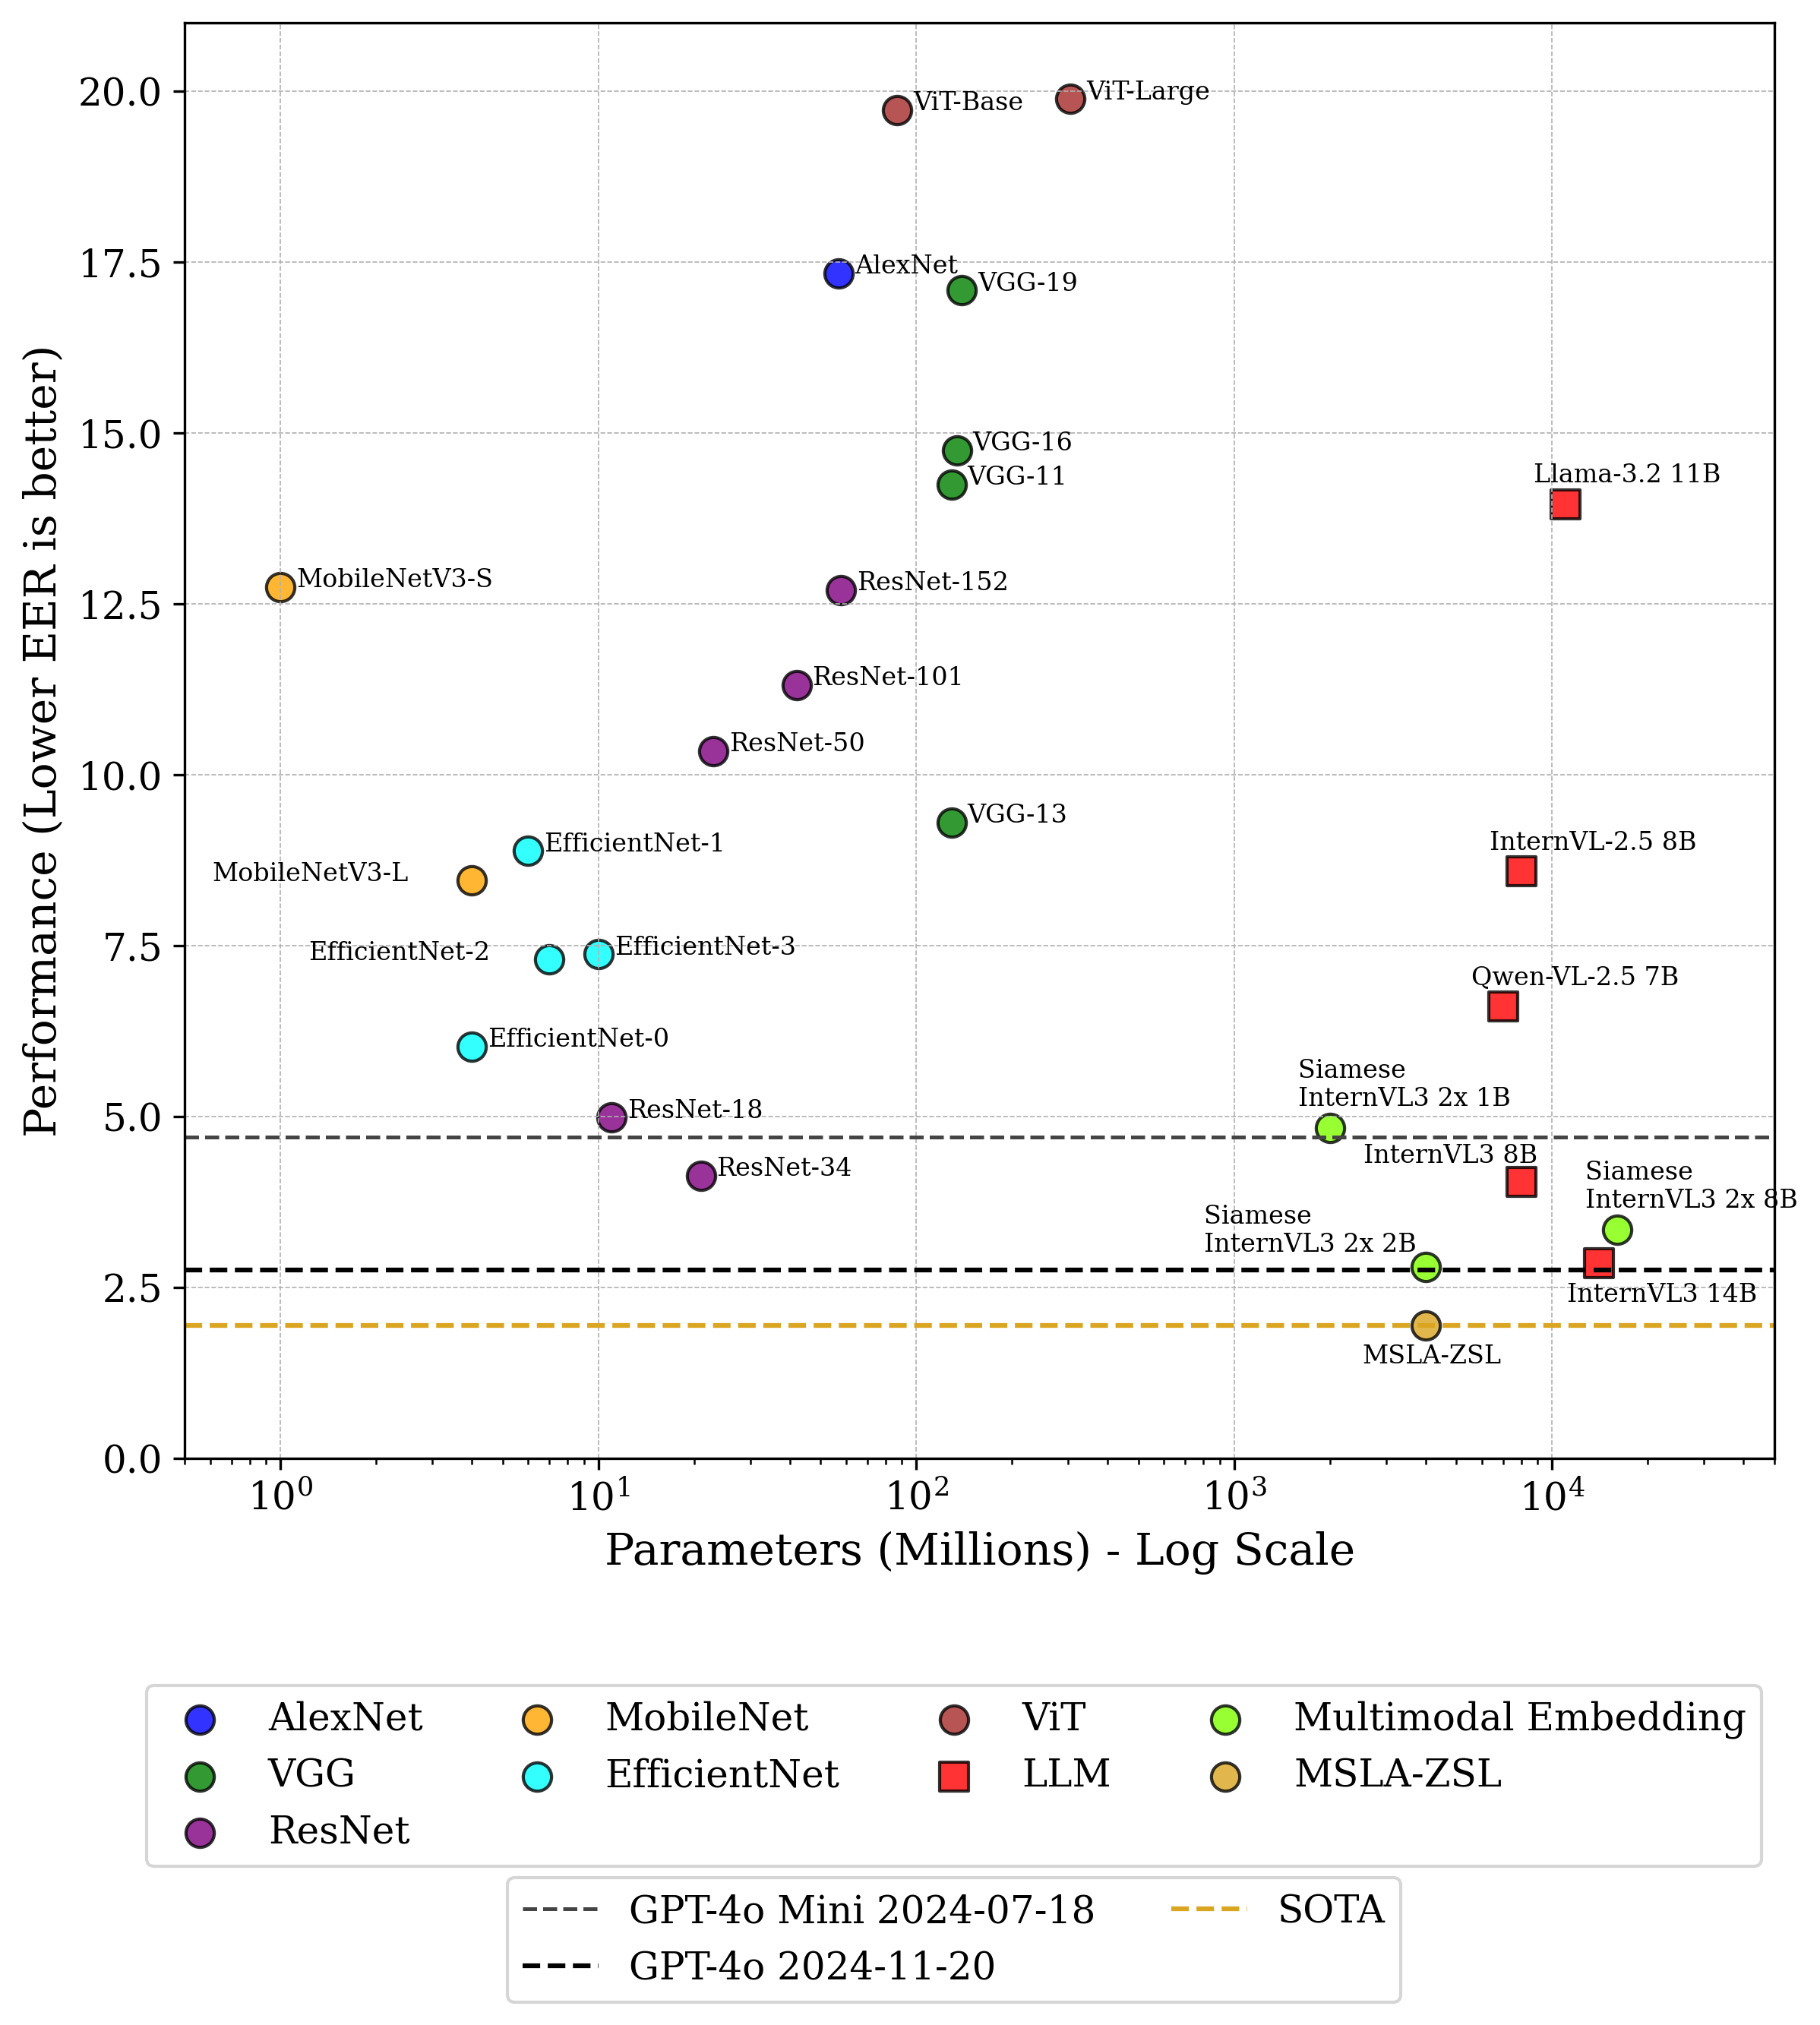

In [178]:
import matplotlib.pyplot as plt
import numpy as np
# from adjustText import adjust_text  # Biblioteca para evitar sobreposição de labels

# Configuração de fonte para publicação científica
# plt.rcParams.update({"font.family": "serif", "font.size": 12})

# Dados extraídos da tabela
models = [
    # (Nome, Arquitetura, Parâmetros (em milhões), Test ZSL)
    ("AlexNet", "AlexNet", 57, 17.33),
    ("VGG-11", "VGG", 129, 14.24),
    ("VGG-13", "VGG", 129, 9.30),
    ("VGG-16", "VGG", 134, 14.74),
    ("VGG-19", "VGG", 139, 17.08),
    ("ResNet-18", "ResNet", 11, 4.98),
    ("ResNet-34", "ResNet", 21, 4.13),
    ("ResNet-50", "ResNet", 23, 10.34),
    ("ResNet-101", "ResNet", 42, 11.31),
    ("ResNet-152", "ResNet", 58, 12.70),
    ("MobileNetV3-S", "MobileNet", 1, 12.74),
    ("MobileNetV3-L", "MobileNet", 4, 8.45),
    ("EfficientNet-0", "EfficientNet", 4, 6.02),
    ("EfficientNet-1", "EfficientNet", 6, 8.88),
    ("EfficientNet-2", "EfficientNet", 7, 7.29),
    ("EfficientNet-3", "EfficientNet", 10, 7.37),
    ("ViT-Base", "ViT", 87, 19.72),
    ("ViT-Large", "ViT", 305, 19.88),
    ("Llama-3.2 11B", "LLM", 11000, 13.95),
    ("InternVL-2.5 8B", "LLM", 8000, 8.58),
    ("Qwen-VL-2.5 7B", "LLM", 7000, 6.61),
    ("InternVL3 2B", "LLM", 2000, 38.98),
    ("InternVL3 8B", "LLM", 8000, 4.04),
    ("InternVL3 14B", "LLM", 14000, 2.85),
    ("Siamese \nInternVL3 2x 1B", "Multimodal Embedding", 2000, 4.83),
    ("Siamese \nInternVL3 2x 2B", "Multimodal Embedding", 4000, 2.79),
    ("Siamese \nInternVL3 2x 8B", "Multimodal Embedding", 16000, 3.34),
    ("MSLA-ZSL", "MSLA-ZSL", 4000, 1.94)   
]

# Modelos GPT-4o (Sem quantidade de parâmetros conhecida) como referência
gpt4o_mini = (None, 4.70)
gpt4o = (None, 2.75)

# Definir cores para cada arquitetura
architecture_colors = {
    "AlexNet": "blue",
    "VGG": "green",
    "ResNet": "purple",
    "MobileNet": "orange",
    "EfficientNet": "cyan",
    "ViT": "brown",
    "LLM": "red",
    "Multimodal Embedding": "chartreuse",
    "MSLA-ZSL": "goldenrod"

}

# Definir símbolos para cada tipo de modelo
marker_styles = {
    "LLM": "s",  # Quadrado para LLMs
    "Default": "o"  # Círculo para arquiteturas de visão
}

# Criar gráfico
fig, ax = plt.subplots(figsize=(9, 9), dpi=300)

# Criar um dicionário para rastrear os rótulos adicionados à legenda
added_labels = {}

# Lista para armazenar os textos dos labels para ajuste automático
text_labels = []

# Plotar os pontos para os modelos com parâmetros conhecidos
for model in models:
    name, arch, params, test_zsl = model
    color = architecture_colors.get(arch, "black")
    marker = marker_styles["LLM"] if arch == "LLM" else marker_styles["Default"]

    # Adicionar pontos ao gráfico
    scatter = ax.scatter(params, test_zsl, color=color, marker=marker, alpha=0.8, edgecolors="black", s=80)

    # Adicionar rótulo à legenda apenas uma vez por arquitetura
    if arch not in added_labels:
        added_labels[arch] = scatter

    # Ajuste da posição do texto para os modelos específicos
    if name == "MobileNetV3-L":
        xytext_offset = (-82, 0)  # Label abaixo
    elif name == "EfficientNet-2":
        xytext_offset = (-76, 0)  # Label à esquerda
    elif name == "ResNet-34":
        xytext_offset = (5, 0)  # Label à esquerda
    elif name == "Siamese \nInternVL3 2x 2B":
        xytext_offset = (-70, 5)  # Label à esquerda
    elif name == "MSLA-ZSL":
        xytext_offset = (-20, -12)  # Label à esquerda
    elif name == "InternVL3 8B":
        xytext_offset = (-50, 6)  # Label à esquerda
    elif name == "InternVL3 14B":
        xytext_offset = (-10, -12)  # Label à esquerda
    elif params > 1000:
        xytext_offset = (-10, 7)  # Ajuste para LLMs (evitar corte)
    else:
        xytext_offset = (5, 0)  # Padrão para os demais modelos

    # Criar texto dos labels sem sobreposição
    text = ax.annotate(name, (params, test_zsl), fontsize=8, xytext=xytext_offset, textcoords="offset points")
    text_labels.append(text)

# Ajustar automaticamente os labels para evitar sobreposição
# adjust_text(text_labels, arrowprops=dict(arrowstyle="-", color="gray", lw=0.5))

# Adicionar linhas de referência para GPT-4o e GPT-4o Mini
ax.axhline(y=gpt4o_mini[1], color="#444444", linestyle="--", linewidth=1.2, label="GPT-4o Mini 2024-07-18")
ax.axhline(y=gpt4o[1], color="black", linestyle="--", linewidth=1.5, label="GPT-4o 2024-11-20")
ax.axhline(y=1.94, color="goldenrod", linestyle="--", linewidth=1.5, label="SOTA")


# Configuração dos eixos
ax.set_xscale("log")  # Aplicando escala logarítmica ao eixo X
ax.set_xlabel("Parameters (Millions) - Log Scale", fontsize=14)
ax.set_ylabel("Performance (Lower EER is better)", fontsize=14)
# ax.set_title("Performance vs Activated Parameters (ZSL)", fontsize=16)

# Expandir limite do eixo X para que fique um pouco além de 10^4
ax.set_xlim([0.5, 5e4])
ax.set_ylim([0, 21])

# Reduzir a quantidade de gridlines para um visual mais limpo
ax.grid(visible=True, which="major", linestyle="--", linewidth=0.4)  # Apenas gridlines principais
ax.grid(visible=False, which="minor")  # Oculta gridlines menores

# Criar legenda separada abaixo do gráfico
fig.subplots_adjust(bottom=0.18)  # Ajusta o espaço para a legenda
legend_ax = fig.add_axes([0.1, 0.02, 0.8, 0.01])  # Criando espaço abaixo do gráfico
legend_ax.axis("off")  # Remove os eixos da área da legenda

# Criar legenda com os elementos únicos
legend_ax.legend(added_labels.values(), added_labels.keys(), loc="center", ncol=4, fontsize=12)

# Criar legenda separada para as linhas de referência
handles, labels = ax.get_legend_handles_labels()
reference_legend = fig.add_axes([0.1, -0.08, 0.8, 0.05])  # Criando outra legenda abaixo
reference_legend.axis("off")
reference_legend.legend(handles, labels, loc="center", ncol=2, fontsize=12)

# Exportar imagem em alta qualidade para paper
plt.savefig("performance_vs_parameters.png", dpi=300, bbox_inches="tight")  # Exportação otimizada

# Mostrar gráfico
plt.show()